# Setting up the calibration landscape (ecoregions, initial communities, climate etc.)

# OLD VERSION WITH ENVIRONMENT CANADA MODELS AND GAMS

Now that we have initial parameters for our species, we need to define the landscape in which the calibration will take place.

To adapt to the Python functions I've made for these Jupyter Notebooks (see [here](./functionsForCalibration.py)), simulations will take place on a single cell. 

What we need is :

- The climate file
- The ecoregion file and PnET ecoregion parameters
- Initial communities files

## The climate file

See [Gustafson and Miranda (2023)](./ReferencesAndData/Gustafson2024PnETUserGuide.pdf) for detailed information about what the climate file used in PnET simulations must contain.

[Gustafson and Miranda (2023)](./ReferencesAndData/Gustafson2024PnETUserGuide.pdf) recommends using a constant climate for calibrating (p. 69). Gustafson also recommends using an "ideal" climate at some points, but deciding what is an ideal climate for a given species is a difficult proposition. As we are going to compare the growth curves generated by PnET Succession with the growth curves generated by an empirical model like FVS (see [next section](./5.Obtaining_Growth_data_from_FVS.ipynb)), the idea will be rather to get long-term monthly averages (as recommanded by [Gustafson and Miranda (2023)](./ReferencesAndData/Gustafson2024PnETUserGuide.pdf) p. 73) **in the region of the FVS variant that we are going to use** (or, if something else than FVS is used, long-term averages for the region where the empirical data comes from).

We have 5 variables that we need to gather :

- Maximum Monthly temperature (°C)
- Minimum Monthly temperature (°C)
- Photosynthetically Active Radiation (umol/m2/s)
- Sum of precipitations during the month (mm)
- Mean monthly atmospheric CO2 concentration (ppm)

### Climate data location for the calibration

Since we're doing calibration simulation here, we don't have a particular place where our simulation take place. It's up to us to choose where the climate data comes from, and there is not a "best" way to do things.

It's surely most likely better to use climate conditions that are closer to the average of the conditions we want to simulate in other LANDIS-II simulation rather than to extremes (especially for this first step of calibration). We also want to make sure that the location we use ca be inputted in FVSon.

I propose that we use an area near the border between the boral and temperate forest, and near the center of Ontario. It will be arbitrary.

Here is a map from of the forests of Ontario from the 2016 forest report of Ontario :

![](https://files.ontario.ca/1a-forestregion-map_e_1.png)

The city of [Chapleau](https://www.openstreetmap.org/#map=12/47.8416/-83.4106) seems to be located near the limit between the boreal and temperate forest. I created a simple shapefile polygon around the city that will serve to clip the climate data we want. See the next cell for a map.

In [29]:
# Displays a map where the shapefile that defines the boundaries of the climate data we wanna use is
import geopandas as gpd
import folium
from folium.features import GeoJsonPopup, GeoJsonTooltip

# Load the shapefile
# Replace 'path_to_shapefile.shp' with your actual shapefile path
gdf = gpd.read_file("./ReferencesAndData/ChapleauBoundariesClimate.shp")

# Check the CRS (Coordinate Reference System) of the shapefile
# If not in WGS84 (EPSG:4326), reproject it
if gdf.crs != 'EPSG:4326':
    gdf = gdf.to_crs('EPSG:4326')

# Create a map centered on the mean of the shapefile bounds
center_lat = gdf.unary_union.centroid.y
center_lon = gdf.unary_union.centroid.x
m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

# Add the GeoJSON data to the map with some styling
folium.GeoJson(
    gdf,
    name='Polygons',
    style_function=lambda x: {
        'fillColor': '#ebcb8b',
        'color': '#2e3440',
        'weight': 1,
        'fillOpacity': 0.4
    }
).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Alternatively, you can use this simpler approach which works in newer versions of JupyterLab
display(m)

### Climate data source for 🌡️ temperature and 🌧️ precipitation

There are many sources of climate data. However, in this documentation, we will want to access both historical data and future data based on different scenarios for the different steps of the calibration. As such, we need :

- Data for all of Canada (since we want to do simulations throughout Canada in the DIVERSE project)
- Data that takes into account different Climate Models (e.g. ensemble data, percentiles, etc.) to take into account model variability
- Data that gives predictions of maximum and minimum temperatures, along with monthly sums of precipitations
- (Optional, but very useful) data that we can process easily through Python code to make things replicable.

I've looked at several data sources ([NclimGrid](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc:C00332), [here](https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily), [here](https://berkeleyearth.org/data/) etc.); but all were either just for the US, or just for historical data. We also have Worldclim and ClimateNA which are good, but of lesser quality from the one I choosed below.

In the end, the data from [climatedata.ca](https://climatedata.ca/) was the most adapted. I contacted them, and they sent me links to their [very detailed documentation](https://pavics.ouranos.ca/climate_analysis.html) allowing us to access their data with the OPeNDAP procotol, which avoids downloading the whole datasets - and make us able to access only the spatial/temporal chuncks we need.

The data we're using here comes from the future projection dataset [CanDSC-M6](https://climatedata.ca/resource/intro-to-candcs-m6/), which contains downscaled data from several Global Climate Models with a state-of-the-art methodology. See the following cell for data extraction.

However, **we are not going to use ensemble data** (percentiles accross several climate models) from CanDSC-M6, but rather data from a single climate model. This is because variables like temperature and precipitation have a great variability from month to month or year to year. Some years can see droughts, some years can see more rain. If we use ensemble data, we take into account inter-variability, but we completly loose the intra-model variability - which is crucial to model the more extreme conditions we see in real life when compared to the very "mild" and very average values obtained through percentiles.

We can see it clearly on this figure, which I generated with previous version of code from this notebook. The blue curve is precipitation data from a single climate model run; the orange curve is percentile data accross 17 different climate models. Both curve have approximately the same mean/average; but the variability is very different, and much higher in data from a single run.

![](./ReferencesAndData/Climate_Percentile_versus_SingleModel.png)

As such, we'll have to select one of the climate models whose data is available in CanDSC-M6. The idea is to select a model who's output are closest to the concensus/average/median among models, so that we still take into account inter-model variability by avoiding models that are at the extremes of this variability.

The following code cell does this by computing a standardized mean squared error for all 26 models of CanDCS-M6 and our three variables (precipitations, Tmin, Tmax) when compared to the median accross all models. It returns the models that is closest to the median overall, not just for one variable.

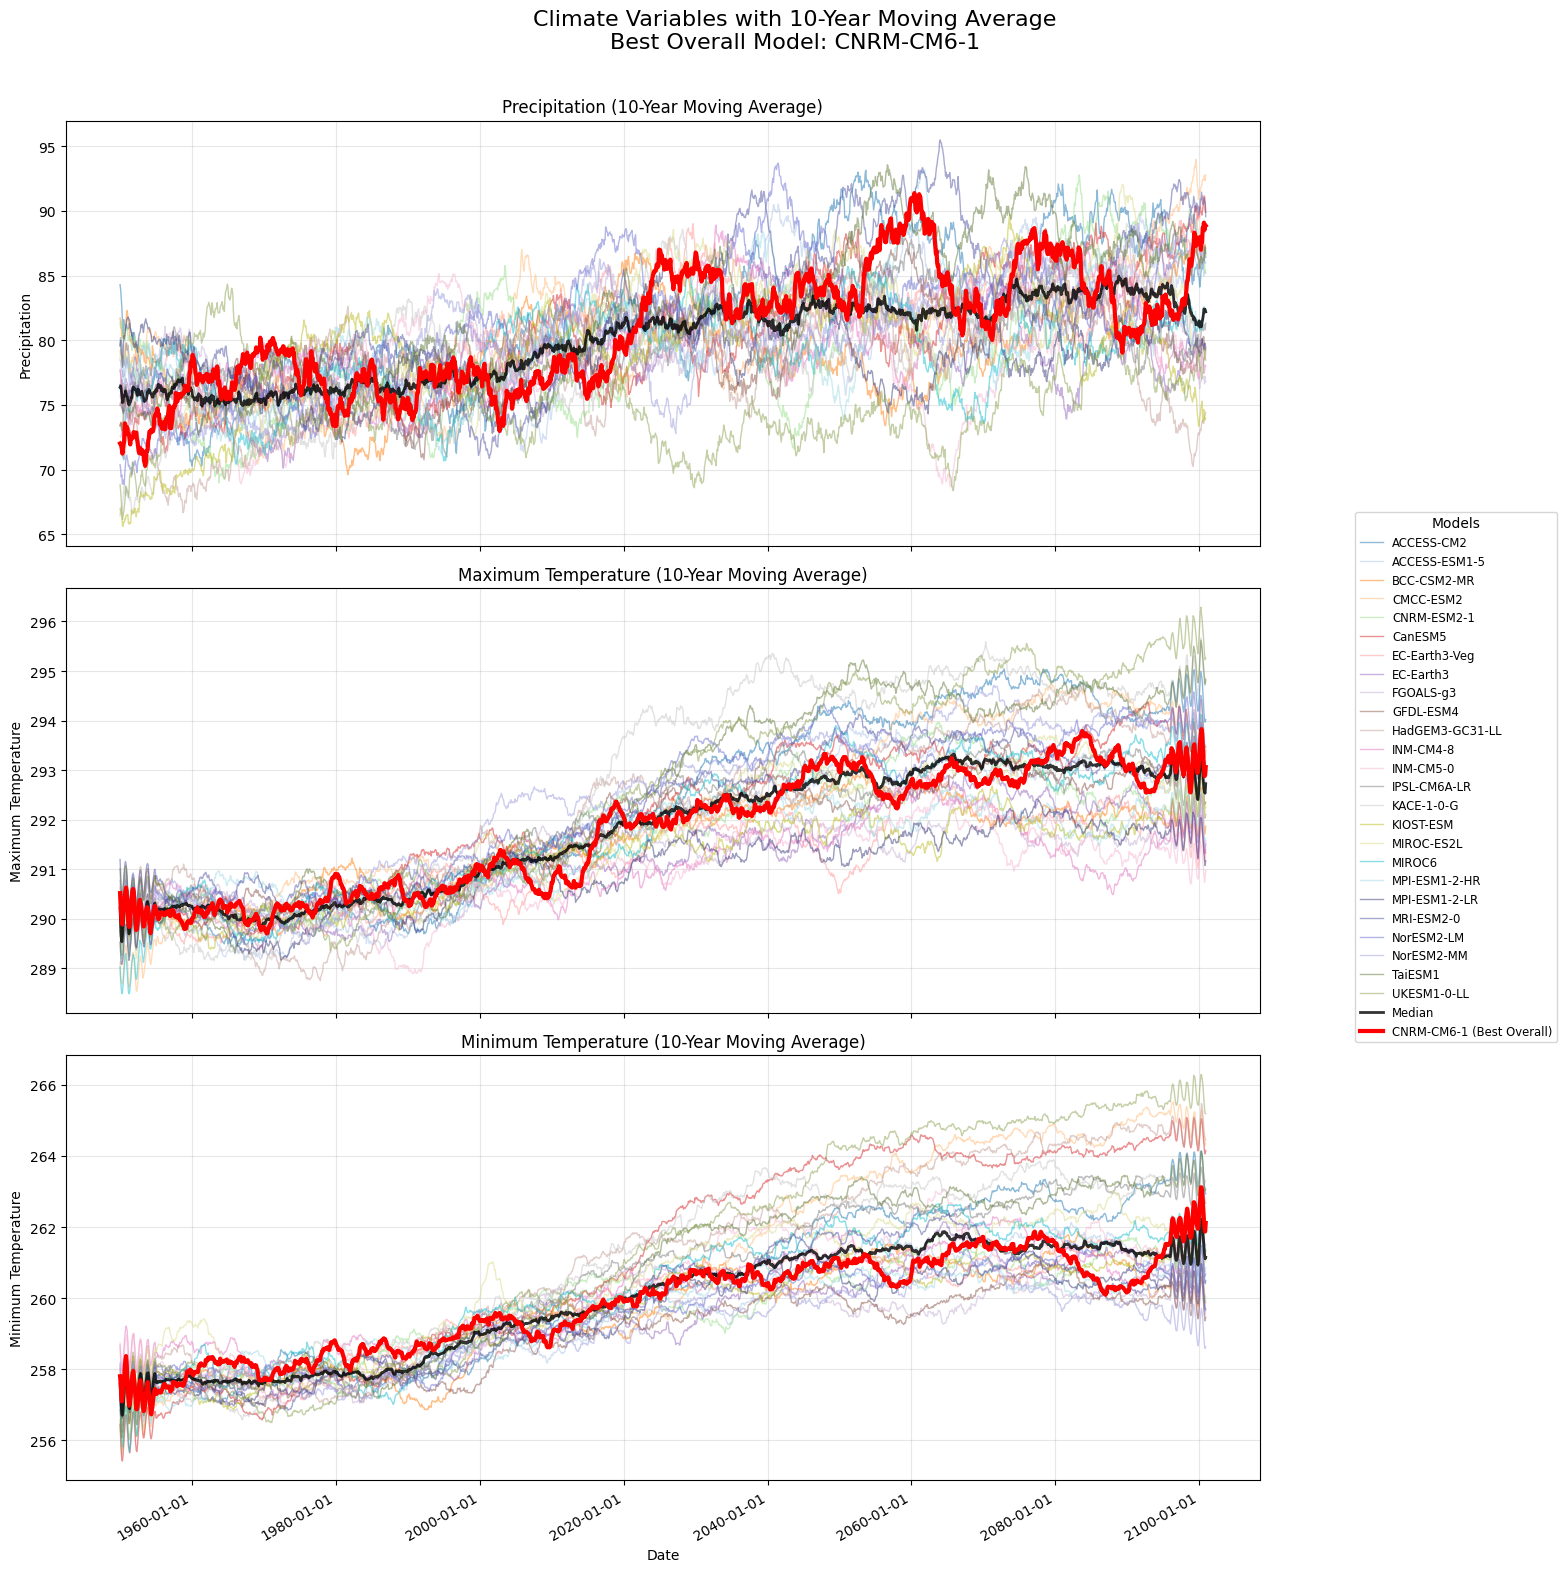

In [1]:
# This cell takes the precipitation, min and max temp data from CanDCS-M6
# and finds the model closts to the median accross all three variables using a standardized mean squarred approach

from functionsForCalibration import *
from siphon.catalog import TDSCatalog
import xarray as xr
from dask.diagnostics import ProgressBar
from IPython.display import display
from clisops.core import subset
import pandas as pd
import numpy as np
from tqdm import tqdm
    
# These URLs was made by browsing the THREDD server catalog of datasets, as was recommanded to me by email by the Canadian Centre for Climate Services (ECCC
# It points to the location of monthly total precipitation, Monthly tmax and tmin data for CanDCS-M6, and climate scenario SSP126.
# Here, we are in a folder with 26 different .nc files, corresponding to different GCMs runs
# We will loop to display each of them on a plot
# We can choose the ssp scenario; CanDCS-M6 has ssp126 (1-2.6), ssp245 (2-4.5), ssp370 (3-7.0), and ssp 585 (5-8.5).
sspScenario = "ssp126" # We use 126 for now as we'll do the calibration on historical, averaged data in the end anyway.
dictOfVariablesURL = {"prcptot":"https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/catalog/birdhouse/disk2/cccs_portal/indices/Final/CanDCS-M6/prcptot/MS/" + sspScenario + "/simulations/catalog.xml",
                     "tn_min":"https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/catalog/birdhouse/disk2/cccs_portal/indices/Final/CanDCS-M6/tn_min/MS/" + sspScenario + "/simulations/catalog.xml",
                     "tx_max":"https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/catalog/birdhouse/disk2/cccs_portal/indices/Final/CanDCS-M6/tx_max/MS/" + sspScenario + "/simulations/catalog.xml"}

dictOfResults = {}

for variable in dictOfVariablesURL:
    # Create Catalog object
    cat = TDSCatalog(dictOfVariablesURL[variable])

    # Create dictionnary to fill with values
    variableMonthlyDict = dict()
    
    for datasetID in range(0, len(cat.datasets)):
        # Selects the dataset
        cds = cat.datasets[datasetID]
        # Gets the model name from the .nc file name
        modelName = str(cds).replace("_historical+" + sspScenario + "_1950-2100.nc", "").replace(variable + "_mon_MBCn+PCIC-Blend_", "")
        # Get the data for the Chapleau area
        ds = xr.open_dataset(cds.access_urls["OPENDAP"], chunks="auto")
        ds1 = subset.subset_shape(ds,
                                  shape="./ReferencesAndData/ChapleauBoundariesClimate.shp")
        ds_months = ds1[variable].isel(time=slice(0, 1812))
        # With this command, we can get the monthly averages across all cells in one very quick step
        # Instead of going from month to month with listOfPrecTotMonthly.append(float(testds.isel(time=month).mean().values))
        # Here, we use mean() to get the mean values accross all of the  cells in our polygon.
        # This works for precipitations too as mm are not dependent on the surface; 1mm of precipitation = 1l per m2. PnET takes
        # the same unit, so it's OK.
        listOVariableMonthly = ds_months.mean(dim=['lat', 'lon']).values.tolist()
        # We put the values in the dictionnary
        variableMonthlyDict[modelName] = listOVariableMonthly

    dictOfResults[variable] = variableMonthlyDict

# We create the list of years/months to plot
years = np.repeat(np.arange(1950, 2101), 12)
# Create months 1-12 for each year
months = np.tile(np.arange(1, 13), 2101-1950)
datesTime = [(str(year) + "-" + str(month).zfill(2) + "-01") for (month, year) in zip(months, years)]

fig, bestModel, modelScore = plot_climate_variables_with_moving_average(dictOfResults["prcptot"], dictOfResults["tx_max"], dictOfResults["tn_min"], datesTime, window_years=10)

This method allows us to select the model that fits in an automatized way, depending on the landscape we're working on. This will be useful for the main simulations we will do afterward for DIVERSE.

Different SSP scenarios give different fits, but it seems pretty robust to the size of the moving window we're using. But in the calibration, we'll use historical data. So, let's do it again for historical data :

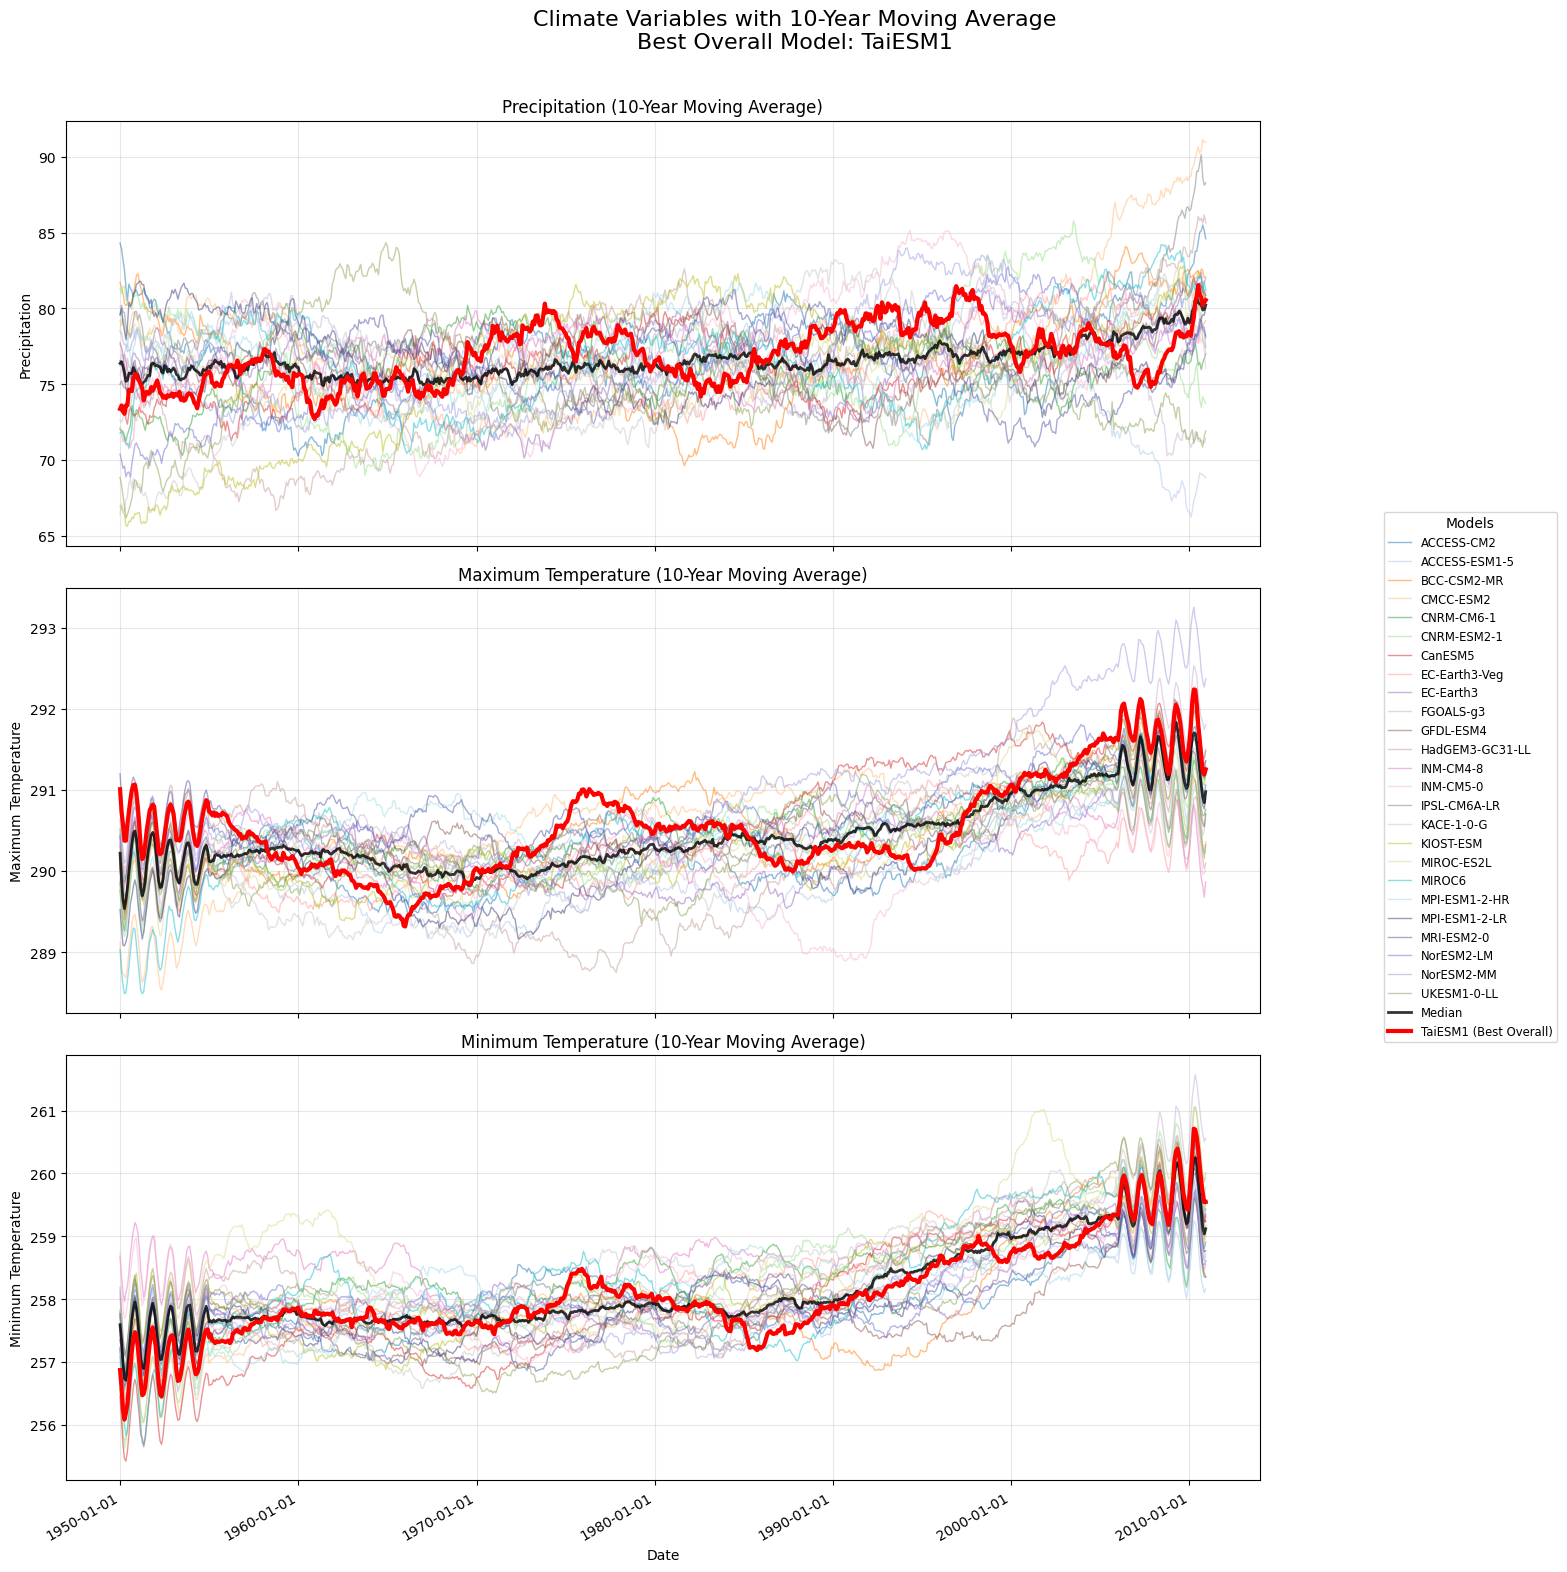

In [2]:
# We will now do the same as before, but use only data from 1950-2010, meaning the 732 first months of the sample.
import copy
dictOfResults_SampleHistorical = copy.deepcopy(dictOfResults)

for variable in dictOfResults_SampleHistorical:
    for model in dictOfResults_SampleHistorical[variable]:
        dictOfResults_SampleHistorical[variable][model] = dictOfResults_SampleHistorical[variable][model][0:732]

fig, bestModel, modelScore = plot_climate_variables_with_moving_average(dictOfResults_SampleHistorical["prcptot"],
                                                                        dictOfResults_SampleHistorical["tx_max"],
                                                                        dictOfResults_SampleHistorical["tn_min"],
                                                                        datesTime[0:732], window_years=10)

However, as recommanded by [Gustafson and Miranda (2023)](./ReferencesAndData/Gustafson2024PnETUserGuide.pdf), we will transform these climate conditions into constant conditions (accross the year, but variable between month) to avoid confounding the first step of the calibration with extreme events.

Now, let's try the [model selection method from Xclim](https://xclim.readthedocs.io/en/stable/apidoc/xclim.ensembles.html#xclim.ensembles._reduce.kmeans_reduce_ensemble), which seems based on the litterature (in contrast to what I just done before, which I've thought of myself).

/usr/local/lib/python3.10/dist-packages/xclim/ensembles/_reduce.py:366: UserWarning: 6 clusters has been found to be the optimal number of clusters, but limiting to 1 as required by user provided max_clusters
  n_clusters = _get_nclust(


Selected models:
- CNRM-ESM2-1


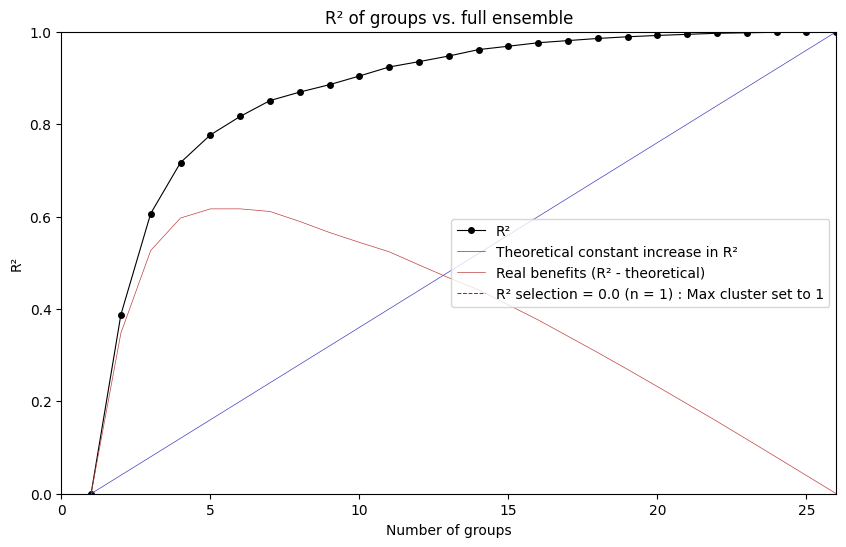

In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from xclim.ensembles import kmeans_reduce_ensemble, plot_rsqprofile

# Create a time index from 1950 to 2100 (monthly data)
start_date = '1950-01-01'
end_date = '2100-12-01'
time_index = pd.date_range(start=start_date, end=end_date, freq='MS')[:1812]

# Get the list of climate models (assuming all variables have the same models)
climate_models = list(dictOfResults['prcptot'].keys())
variables = list(dictOfResults.keys())

# First, create an xarray dataset from the dictionary
ds_dict = {}

for var_name in variables:
    # Create a data array for each variable
    data = np.array([dictOfResults[var_name][model] for model in climate_models])

    da = xr.DataArray(
        data,
        dims=('model', 'time'),
        coords={
            'model': climate_models,
            'time': time_index
        },
        name=var_name
    )

    ds_dict[var_name] = da

# Combine all variables into a single dataset
ds = xr.Dataset(ds_dict)

# Now, we need to prepare the data for kmeans_reduce_ensemble
# We'll compute the mean of each variable for each model to use as criteria
criteria_data = []
for var in variables:
    # Calculate the mean of each variable for each model
    criteria_data.append(ds[var].mean(dim='time').values)

# Stack the criteria data
criteria_data = np.array(criteria_data).T  # Shape: (n_models, n_variables)

# Create a DataArray with dimensions 'realization' and 'criteria'
criteria_da = xr.DataArray(
    criteria_data,
    dims=('realization', 'criteria'),
    coords={
        'realization': climate_models,
        'criteria': variables
    }
)

# Apply K-Means ensemble reduction to select 4 representative models
selected_models, kMeanClusterResults, rsq_profile = kmeans_reduce_ensemble(
    criteria_da,
    max_clusters=1,
    make_graph =True
)

print("Selected models:")
for modelIndex in selected_models:
    model = list(dictOfResults["tx_max"].keys())[modelIndex]
    print(f"- {model}")

# Plot the variance explained profile
plot_rsqprofile(rsq_profile)

# Create a subset of the dataset with only the selected models
# ds_selected = ds.sel(model=selected_models)

# print("\nDataset with selected models:")
# print(ds_selected)

# Optional: Calculate and print the total variance explained by the 4 selected models
# total_variance_explained = rsq_profile[4]
# print(f"\nTotal variance explained by the 4 selected models: {total_variance_explained:.2%}")


Of course, this method is not made to select one model, but several. It seems that 6 models is optimal here. Maybe this could be use a 6 "climate replicates" in our simulations for theme 4 of DIVERSE later on.

Now, I'll highlight the model choosen by Xclim in comparison to the others :

/usr/local/lib/python3.10/dist-packages/xclim/ensembles/_reduce.py:366: UserWarning: 5 clusters has been found to be the optimal number of clusters, but limiting to 1 as required by user provided max_clusters
  n_clusters = _get_nclust(
/calibrationFolder/calibrationJupyterBook/StartingCalibrationTest/functionsForCalibration.py:2836: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  legend = fig.legend(all_lines, all_labels, loc='center right',


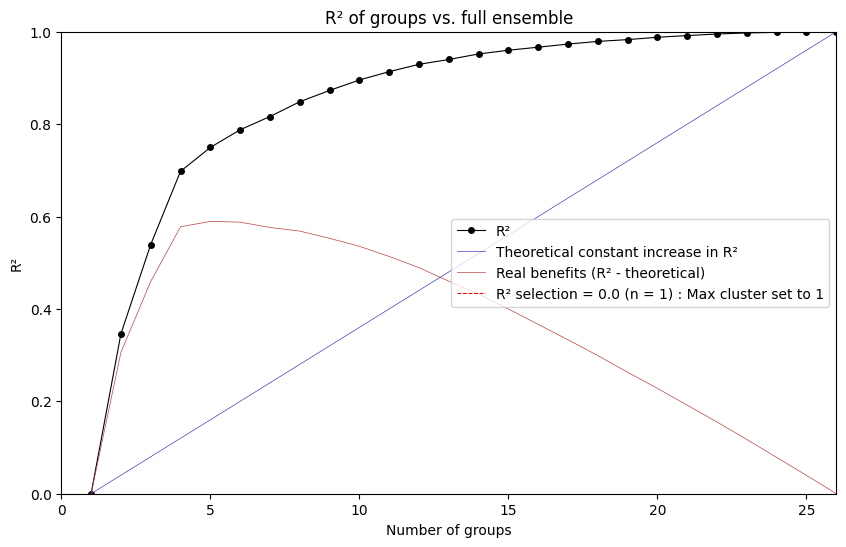

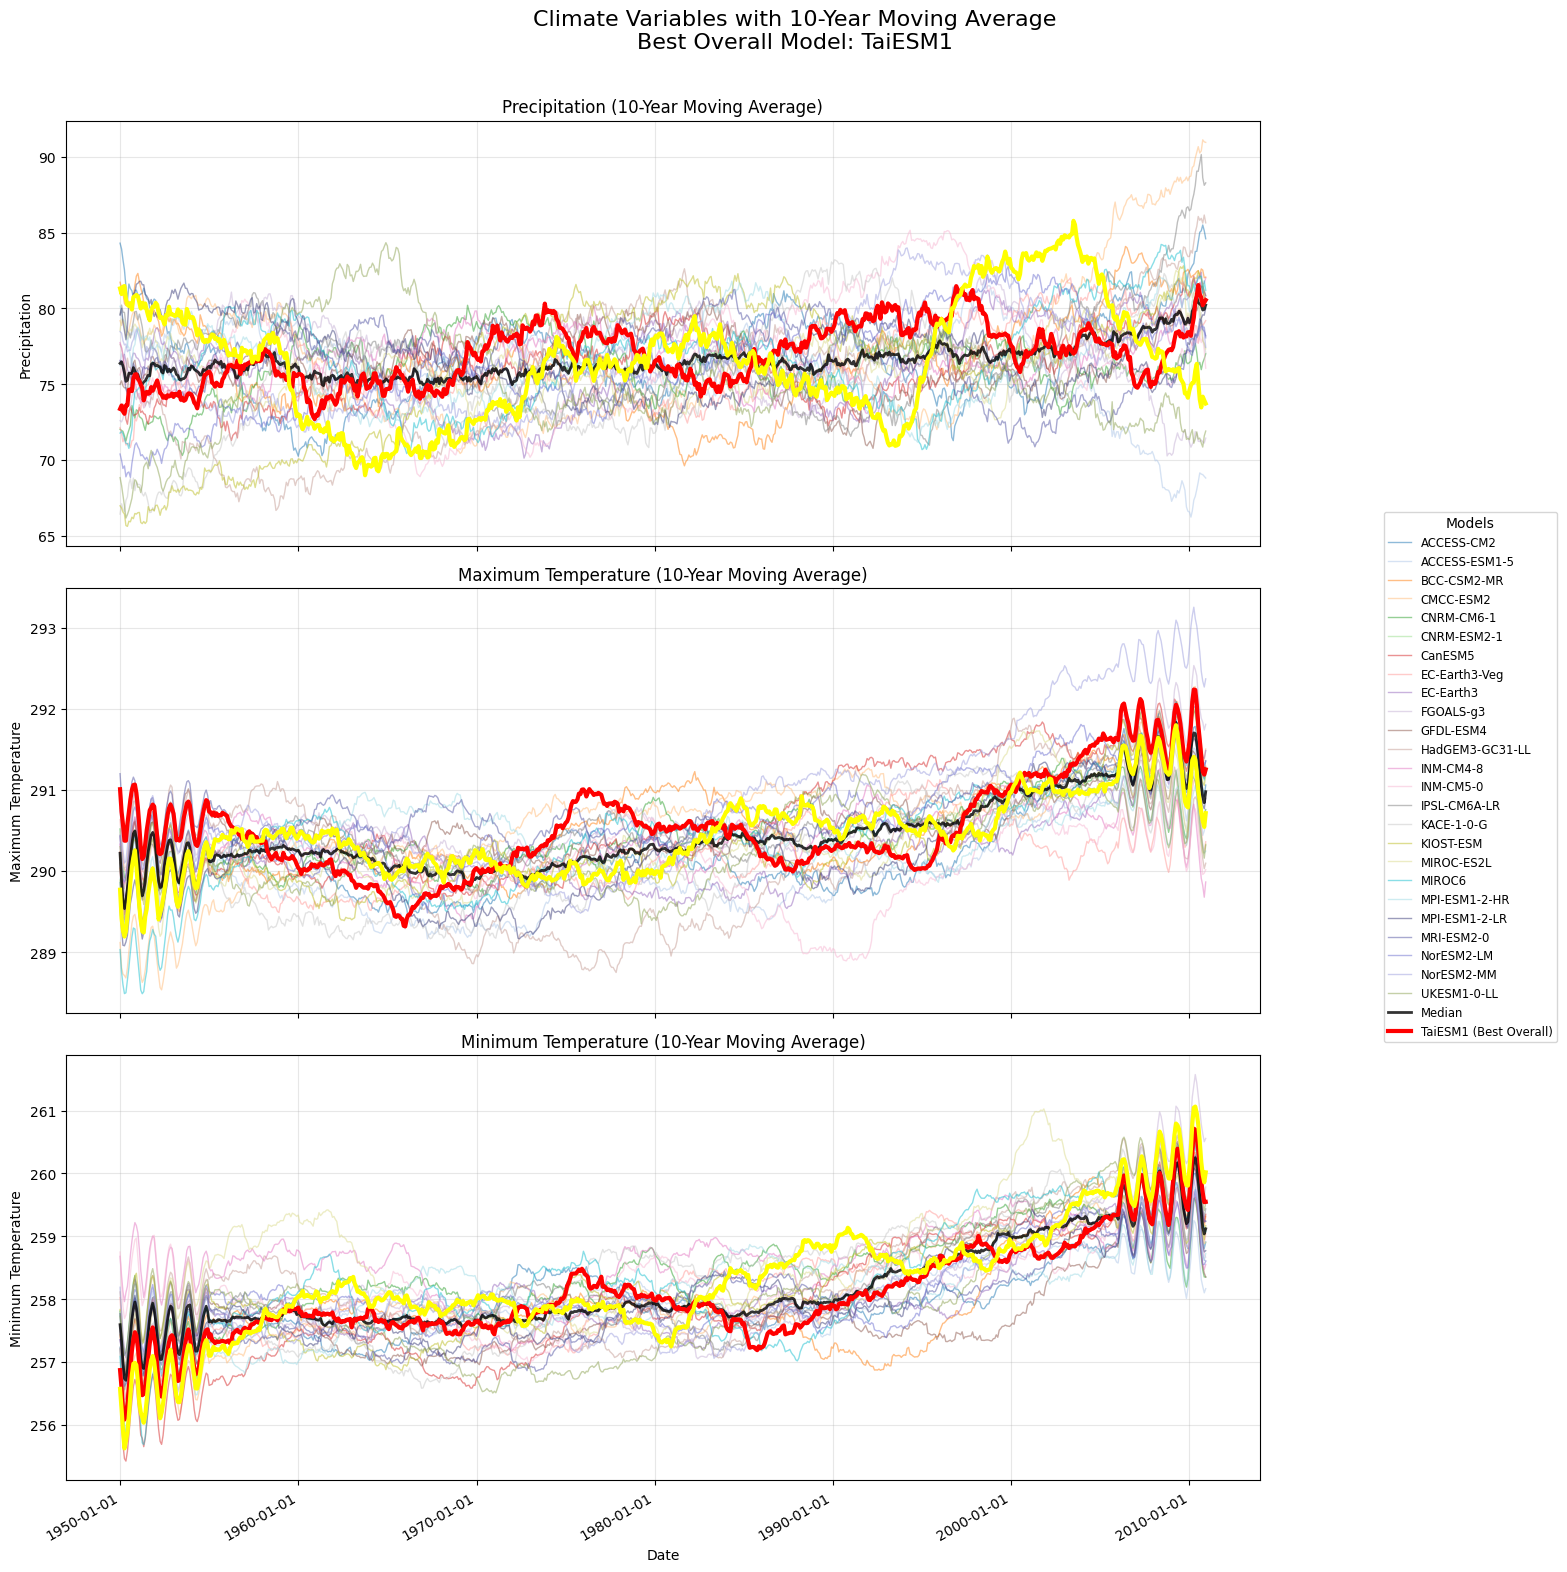

In [4]:
# We will now do the same as before, but use only data from 1950-2010, meaning the 732 first months of the sample.
# Get the list of climate models (assuming all variables have the same models)
# Create a time index from 1950 to 2010 (monthly data)
start_date = '1950-01-01'
end_date = '2010-12-01'
time_index = pd.date_range(start=start_date, end=end_date, freq='MS')[:732]

climate_models = list(dictOfResults_SampleHistorical['prcptot'].keys())
variables = list(dictOfResults_SampleHistorical.keys())

# First, create an xarray dataset from the dictionary
ds_dict = {}

for var_name in variables:
    # Create a data array for each variable
    data = np.array([dictOfResults_SampleHistorical[var_name][model] for model in climate_models])

    da = xr.DataArray(
        data,
        dims=('model', 'time'),
        coords={
            'model': climate_models,
            'time': time_index
        },
        name=var_name
    )

    ds_dict[var_name] = da

# Combine all variables into a single dataset
ds = xr.Dataset(ds_dict)

# Now, we need to prepare the data for kmeans_reduce_ensemble
# We'll compute the mean of each variable for each model to use as criteria
criteria_data = []
for var in variables:
    # Calculate the mean of each variable for each model
    criteria_data.append(ds[var].mean(dim='time').values)

# Stack the criteria data
criteria_data = np.array(criteria_data).T  # Shape: (n_models, n_variables)

# Create a DataArray with dimensions 'realization' and 'criteria'
criteria_da = xr.DataArray(
    criteria_data,
    dims=('realization', 'criteria'),
    coords={
        'realization': climate_models,
        'criteria': variables
    }
)

# Apply K-Means ensemble reduction to select 4 representative models
selected_models, kMeanClusterResults, rsq_profile = kmeans_reduce_ensemble(
    criteria_da,
    max_clusters=1,
    make_graph =True
)

# We get the name of the model choosen by Xclim; Xclim returns its index, so we go and take
# the model name in the original dict with the data
modelChoosenByXclim = list(dictOfResults_SampleHistorical["tx_max"].keys())[selected_models[0]]

# print("Selected models:")
# for modelIndex in selected_models:
#     model = list(dictOfResults_SampleHistorical["tx_max"].keys())[modelIndex]
#     print(f"- {model}")

# Plot the variance explained profile
plot_rsqprofile(rsq_profile)

fig, bestModel, modelScore = plot_climate_variables_with_moving_average(dictOfResults_SampleHistorical["prcptot"],
                                                                        dictOfResults_SampleHistorical["tx_max"],
                                                                        dictOfResults_SampleHistorical["tn_min"],
                                                                        datesTime[0:732], window_years=10,
                                                                        highlightModel = modelChoosenByXclim)

As we can see, Xclim chooses a different model than the least-square method I used (yellow curve in the plot, corresponding to CNRM-ESM2-1), although they are not enormously different. The one choosen by Xclim (CNRM-ESM2-1) is apparently often recommanded as the model closest to the median; here, it shows more variability than TaiESM1 choosen by the least-square method. It surely makes sense as Xclim tries to capture the variability of the dataset of all of the models.

Ideally, we would use several models at once to properly represent the variability in the ensemble (CanDCS-M6). But as we're doing the first step of the calibration here, we just want "ideal" and "average" climate monthly conditions. We'll thus just go with one model, and we will take the one selected by Xclim instead of the least-square method.

#### Extraction of 🌡 temperature and 🌧 precipitation data for Ontario, 1950-2100 from [CanDSC-M6](https://climatedata.ca/resource/intro-to-candcs-m6/)

The following cells are based on the documentation of Ouranos (the institution behind [climatedata.ca](https://climatedata.ca/) and [CanDSC-M6](https://climatedata.ca/resource/intro-to-candcs-m6/)) to access the data in Python.

They extract the climate variables (Tmax, Monthly Tmin, Sum of precipitations) at a monthly timestep for the different "cells" in the CanDSC-M6 (since the data is gridded on all of the earth), and then make a global value for the small landscape that we're simulating (average of Tmin, Tmax and precipitation sum for across all cells for the month).

In [9]:
# The code in this cell loads the functions needed to extract the climate data from the PAVIS database from Ouranos,
# using the CanDSC-M6 dataset
# We will use it to extract minimum and maximum monthly temp + total monthly precipitation for climate scenario SSP126
# The code in this cell will be re-used on other pages to generate the values for other climate scenarios
# Right now, it doesn't really matter since the first calibration step (monoculture in best conditions) will use
# historical data

# Importing the packages needed
# Siphon is used to connect to the data,
# xarray is used to manipulate the data objects
# The rest is for progress bars, utilities
# Clisops is used to subset the data based on a polygon
from functionsForCalibration import *
from siphon.catalog import TDSCatalog
import xarray as xr
from dask.diagnostics import ProgressBar
from IPython.display import display
from clisops.core import subset
import pandas as pd
import numpy as np
from tqdm import tqdm

# This function will help us define the URL to get the right dataset,
# corresponding to the right variable; the right SSP scenario; and the right model.
# This URL was made by browsing the THREDD server catalog of datasets, as was recommanded to me by email by the Canadian Centre for Climate Services (ECCC
# It points to the location of monthly maximum temperature data for CanDCS-M6, and climate scenario SSP126. The models are from CIMP6 from the IPCC.
def getURLDatasetCanDCSM6(variable, sspScenario, climateModel):
    
    url = ("https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/disk2/cccs_portal/indices/Final/CanDCS-M6/"
           + str(variable)
           + "/MS/"
           + str(sspScenario)
           + "/simulations/"
           + str(variable)
           + "_mon_MBCn+PCIC-Blend_"
           + str(climateModel)
           + "_historical+ssp126_1950-2100.nc")
    return url

# Selector for the SSP scenario we want
# Here, we're looking for 1950-2010 historical data
# Therefore, it's not that much important. We will use SSP 1-2.6
sspScenario = "ssp126"

# We define the time period of the data we want and prepare the dataframe
# that we will export for PnET - that will ultimatily contain a monthly measure
# of Tmin, Tmax, Precpitations, CO2 and PAR for each months of each year
# Here, we want historical data; I limited to up to 2010 to get conditions
# not too influenced by climate changed. It's arbitrary.
startYear = 1950
endYear = 2010
years = np.repeat(np.arange(startYear, endYear+1), 12)
# Create months 1-12 for each year
months = np.tile(np.arange(1, 13), (endYear+1)-startYear)
# Create DataFrame
df = pd.DataFrame({
    'Year': years,
    'Month': months
})
numberOfMonths = len(df["Month"])

#################################################
# MAXIMUM MONTHLY TEMPERATURE
#################################################
# print(getURLDatasetCanDCSM6("tx_max",
                            # sspScenario,
                            # modelChoosenByXclim))

# This does not download the entire dataset, just the metadata and attributes describing the content.
ds = xr.open_dataset(getURLDatasetCanDCSM6("tx_max",
                                      sspScenario,
                                      modelChoosenByXclim),
                    chunks="auto")

# This prints information about the dataset
# display(ds)

# Subset the dataset by polygon
# What we get in ds1 is an array of grid cells with a third dimension corresponding to time
ds1 = subset.subset_shape(
    ds, shape="./ReferencesAndData/ChapleauBoundariesClimate.shp"
) 

# We select the variable data and months we need - all of them
# 0 is january of 1950. numberOfMonths is the number of months from 1950, defined
# at the beginning of the cell.
ds_months = ds1.tx_max.isel(time=slice(0, numberOfMonths))
# With this command, we can get the monthly averages across all cells in one very quick step
listOfTmaxMonthly = kelvin_to_celsius(ds_months.mean(dim=['lat', 'lon']).values.tolist())
df["Tmax"] = listOfTmaxMonthly

#################################################
# MINIMUM MONTHLY TEMPERATURE
#################################################
# We do the same as before, but for the minimum temperature recorded for the month
ds = xr.open_dataset(getURLDatasetCanDCSM6("tn_min",
                                          sspScenario,
                                          modelChoosenByXclim),
                     chunks="auto")
# Subset by polygon (small extent around the town of Chapleau, Ontario)
ds1 = subset.subset_shape(
    ds, shape="./ReferencesAndData/ChapleauBoundariesClimate.shp"
) 

# We select the variable data and months we need - all of them
ds_months = ds1.tn_min.isel(time=slice(0, numberOfMonths))
# With this command, we can get the monthly averages across all cells in one very quick step
listOfTminMonthly = kelvin_to_celsius(ds_months.mean(dim=['lat', 'lon']).values.tolist())
# print(ds1)
df["Tmin"] = listOfTminMonthly


#################################################
# PRECIPITATIONS
#################################################
# We do the same as before, but for the sum of precipitations for each month
ds = xr.open_dataset(getURLDatasetCanDCSM6("prcptot",
                                          sspScenario,
                                          modelChoosenByXclim),
                     chunks="auto")
# Subset by polygon (small extent around the town of Chapleau, Ontario)
ds1 = subset.subset_shape(
    ds, shape="./ReferencesAndData/ChapleauBoundariesClimate.shp"
) 
# We select the variable data and months we need - all of them
ds_months = ds1.prcptot.isel(time=slice(0, numberOfMonths))
# With this command, we can get the monthly averages across all cells in one very quick step
# Here, we use mean() to get the mean total precipitations for all of the  cells in our polygon.
# Precipitations in mm are not dependent on the surface; 1mm of precipitation = 1l per m2. PnET takes
# the same unit, so it's OK.
listOfPrecTotMonthly = ds_months.mean(dim=['lat', 'lon']).values.tolist()
df["SumOfPrecipitations"] = listOfPrecTotMonthly


#################################################
# EXPORT TO CSV
#################################################
# We output the dataframe to a .csv
df.to_csv("./ReferencesAndData/dataFrameClimate.csv", sep=',', index=False, encoding='utf-8')

print(df)

     Year  Month       Tmax       Tmin  SumOfPrecipitations
0    1950      1  -0.962500 -38.264578            48.433594
1    1950      2   1.412500 -40.311453            34.815105
2    1950      3   2.433344 -31.837500            45.216145
3    1950      4  12.079156 -14.577094            73.825523
4    1950      5  27.235406  -6.316656            56.029949
..    ...    ...        ...        ...                  ...
727  2010      8  27.193750   0.964594           106.750000
728  2010      9  26.912500  -0.045844            32.690105
729  2010     10  21.454156  -5.358344            78.263023
730  2010     11  11.443750 -14.202094           111.296875
731  2010     12   1.912500 -26.571875            37.022137

[732 rows x 5 columns]


### Climate data source for ☀ PAR (Photosynthetically Active Radiation)

Sadly, the CanDSC-M6 dataset used for Tmax, Tmin and Precipitations (see above) doesn't contain PAR data. In fact, after a bit of research, very few global datasets seem to have solar radiation variables, especially for several scenarios of climate change (RCP or SSP scenarios) like we will need in the end for this calibration but also for beyong. For example, ClimateNA or World Clim both do not have solar radiation data.

However, another dataset available from Climate Change Canada has PAR values, that they call Downwelling Shortwave Radiation : it is called [CanLEADv1](https://crd-data-donnees-rdc.ec.gc.ca/CDAS/products/CanLEADv1/Cannon%20et%20al.%20-%202022%20-%20Canadian%20Large%20Ensembles%20Adjusted%20Dataset%20version%201%20%20CanLEADv1.pdf).

Problem is, CanLEADv1 doesn't have the same structure as CanDSC-M6 and doesn't cover many climat scenarios. It only has a "no forcing" scenario and a "RCp 8.5" scenario. Plus, it contains two sets 50 replicates based on two input/observed data, but without any ensemble percentile dataset available. Finally, it's not available through the OpENDAP protocol used above - meaning we have to download the entire datasets to work with it (around 30GB for the files concerning Tmax, Tmin, precipitations and PAR for just one replicate).

Talking with the Canadian Center for Climate Services by email, they recommanded that we use only data from CanLEADv1, and simply use an "indexing" method on Global Warming achieved through the simulation rather than time to get the climate values we want. The method is detailed [here](https://climate-scenarios.canada.ca/?page=CRBCPI-general-summary#5.4-development_of_warming_level-based_change_factors), [here](https://climate-scenarios.canada.ca/?page=buildings-report#2.3-communicating_uncertainty) and [here](https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2015GL063569). Basically, we would only use CanLEADv1 data (also for temperatures and precipitation); and the values we would take from the dataset for a moment T in LANDIS-II would be indexed on a 31-years average value centered on a year where the °C of Global Warming is reached in the climate scenario we are simulating. I'm not entirely sure about this approach; I feel like we would loose a lot of the advantages of the CanDSC-M6 data by using CanLEADv1.

Instead, I set out to use CanLEADv1 data to make a Generalized Additive Model (GAM) to predict PAR (which is in CanLEADv1) from monthly minimum temperature, maximum temperature and total precipitation (three variables we can both obtain for CanDSC-M6 and CanLEADv1). After a bit of experimentation, the GAM that I was able to produce seemed to have a good predictive power. Monthly averaged daily PAR is a very cyclic variable, with only small variations in its peak values for winter and summer.

In particular, I've looked at the difference between the monthly PAR values we are getting with this approach, versus those that were in files sent to us by Brian Sturtevant's team. They look very similar, although the amplitude of the variation of PAR throughout the year is higher in our case. This is very easy to understand : since the climate data I'm working with is higher in the north, then the values for summer and winter have more amplitude than in Minnesota where Brian's team work (because the days in winter and summer are shorter and longer in the north, respectively). So, everything seems fine !

Below is the code to download CanLEADv1 data, clip the data for the area of interested, format it, create a GAM, diagnose it, and then produce predicted values of PAR based on the CanDCS-M6 data we took above for the area.

In [25]:
# First step : We're going to download the data from CanLEADv1 (which contain PAR values),
# and select only what is of interest to us (monthly values inside the polygon of the area
# we are simulating), then format the data into a dataframe we will use to create a GAM (Generalize Additive Model) afterwards.
# WARNING : The climate files from CanLEADv1 are temporarely downloaded one by one in the calibration folder, but are deleted when the operation
# is done, as they are very heavy (betwee 6-8 GB per file, and there are 4 files in total).
# The files are at https://crd-data-donnees-rdc.ec.gc.ca/CDAS/products/CanLEADv1/CanRCM4-EWEMBI-MBCn/r1_r1i1p1/, which
# corresponds to one of the 50 replicates of CanLEADv1 calibrated with the EWEMBI observational dataset.
# See https://crd-data-donnees-rdc.ec.gc.ca/CDAS/products/CanLEADv1 for readmes and documentation.
# WARNING : If a download fails, you can relaunch the cell. Downloads are done with Axel, which can re-start a download from where it was.
from functionsForCalibration import *
shapefile_Chapleau = "ReferencesAndData/ChapleauBoundariesClimate.shp"
canLEADv1_url = r"https://crd-data-donnees-rdc.ec.gc.ca/CDAS/products/CanLEADv1/CanRCM4-EWEMBI-MBCn/r1_r1i1p1/"

# If the file resulting from this cell already exists, we
# propose to the user not to run the cell - in order to not
# download the large file. Helps for re-runs of the notebook.
# Right now, this code only runs if the dataframe already compiled with the
# data we need for the Chapleau area is not already there. That avoids downloading
# around 30GB of data.
# WARNING : You should delete dataInputForModel_CanLEADv1.csv and re-create it
# if you are trying to do this step for another area than Chapleau.
if not os.path.exists("ReferencesAndData/dataInputForModel_CanLEADv1.csv"):
    # confirmation = input("Do you want to run this cell? The dataframe is already here. Running the cell will re-download around 30GB of climate data to re-generate the dataframe. (yes/no): ")
    # if confirmation.lower() == "yes" or confirmation.lower() == "y":
    # We start with the minimum temperature
    # We don't do it if the variable we need is already there
    if 'tasmin_monthly' not in locals():
        # We download the file
        file_name = "tasminAdjust_NAM-44i_CCCma-CanESM2_rcp85_r1_r1i1p1_CCCma-CanRCM4_r2_ECCC-MBCn-EWEMBI-1981-2010_day_19500101-21001231.nc"
        download_file(canLEADv1_url + file_name,
                      file_name)
        # We select only the data pertinent to our needs
        tasmin_ds = load_and_filter_by_polygon_canLEADv1(file_name, shapefile_Chapleau)
        # Transforming temperatures from kelvins to celcius
        tasmin_ds["tasminAdjust"] = kelvin_to_celsius(tasmin_ds["tasminAdjust"]) 
        # Resampling to monthly data
        tasmin_monthly = tasmin_ds.resample(time='1ME').min()
        # Free up memory
        del tasmin_ds
        os.remove(file_name)
    else:
        print("Variable tasmin_monthly exists, skipping download")
    
    # Now with the maximum temperature
    if 'tasmax_monthly' not in locals():
        # We download the file
        file_name = "tasmaxAdjust_NAM-44i_CCCma-CanESM2_rcp85_r1_r1i1p1_CCCma-CanRCM4_r2_ECCC-MBCn-EWEMBI-1981-2010_day_19500101-21001231.nc"
        download_file(canLEADv1_url + file_name,
                      file_name)
        # We select only the data pertinent to our needs
        tasmax_ds = load_and_filter_by_polygon_canLEADv1(file_name, shapefile_Chapleau)
        # Transforming temperatures from kelvins to celcius
        tasmax_ds["tasmaxAdjust"] = kelvin_to_celsius(tasmax_ds["tasmaxAdjust"])
        # Resampling to monthly data
        tasmax_monthly = tasmax_ds.resample(time='1ME').max()
        # Free up memory
        del tasmax_ds
        os.remove(file_name)
    else:
        print("Variable tasmax_monthly exists, skipping download")
    
    # Now with the precipitations
    if 'pr_monthly' not in locals():
        # We download the file
        file_name = "prAdjust_NAM-44i_CCCma-CanESM2_rcp85_r1_r1i1p1_CCCma-CanRCM4_r2_ECCC-MBCn-EWEMBI-1981-2010_day_19500101-21001231.nc"
        download_file(canLEADv1_url + file_name,
                      file_name)
        # We select only the data pertinent to our needs
        pr_ds = load_and_filter_by_polygon_canLEADv1(file_name, shapefile_Chapleau)
        # Transforming precipitations from their original unit - kg m-2 s-1 - into mm per day
        pr_ds["prAdjust"] = pr_ds["prAdjust"]*86400 # Going from seconds to days (86400 seconds in a day)
        # kg m-2 is already mm. So, we successfully went from kg m-2 s-1 to mm/day.
        # Resampling to monthly data
        pr_monthly = pr_ds.resample(time='1ME').sum()
        # Free up memory
        del pr_ds
        os.remove(file_name)
    else:
        print("Variable pr_monthly exists, skipping download")
    
    # We finish with PAR (downwelling shortwave radiation, or rsds in CanLEADv1)
    if 'rsds_monthly' not in locals():
        # We download the file
        file_name = "rsdsAdjust_NAM-44i_CCCma-CanESM2_rcp85_r1_r1i1p1_CCCma-CanRCM4_r2_ECCC-MBCn-EWEMBI-1981-2010_day_19500101-21001231.nc"
        download_file(canLEADv1_url + file_name,
                      file_name)
        # We select only the data pertinent to our needs
        rsds_ds = load_and_filter_by_polygon_canLEADv1(file_name, shapefile_Chapleau)
        # Transforming downwelling shortwave radiation from W/m2 to umol.m2/s-1
        # This one is a complex one. PnET user guide says that if the measure in W/m2 FOR SHORTWAVE (400-700nm), then just multiply it by 4.57.
        # However, if W/m2 measure is for TOTAL solar radiation, then we need another conversion factor to go to the shorwave + umol. See User Guide for more.
        # Here, we're normally in shortwave. I'll confirm by comparing the values to other measurement in PnET climate files.
        # HUGE WARNING : I got it wrong the first time ! PAR is not shortwave at all, but only a sub-part of shortwave.
        # As such, the coefficient is 2.02 as per the PnET Succession user guide, not 4.57.
        rsds_ds["rsdsAdjust"] = rsds_ds["rsdsAdjust"]*2.02
        # Resampling to monthly data
        rsds_monthly = rsds_ds.resample(time='1ME').mean()
        # Free up memory
        del rsds_ds
        os.remove(file_name)
    else:
        print("Variable rsds_monthly exists, skipping download")
    
    # We end up by preparign the data for making the GAM
    print("Preparing data for GAM...")
    # Create a DataFrame for each variable
    tasmin_df = tasmin_monthly["tasminAdjust"].to_dataframe().reset_index()
    tasmax_df = tasmax_monthly["tasmaxAdjust"].to_dataframe().reset_index()
    pr_df = pr_monthly["prAdjust"].to_dataframe().reset_index()
    rsds_df = rsds_monthly["rsdsAdjust"].to_dataframe().reset_index()
    
    # Merge DataFrames
    merged_df = pd.merge(tasmin_df, tasmax_df, on=['time', 'lat', 'lon'])
    merged_df = pd.merge(merged_df, pr_df, on=['time', 'lat', 'lon'])
    merged_df = pd.merge(merged_df, rsds_df, on=['time', 'lat', 'lon'])
    
    # Put time in time format
    merged_df['time'] = merged_df['time'].apply(convert_cftime_to_datetime)
    merged_df["time"] = pd.to_datetime(merged_df['time'], errors='coerce')
    
    # Extract month as a feature
    merged_df['month'] = merged_df['time'].dt.month
    
    # Drop rows with NaN values
    merged_df = merged_df.dropna()
    
    # Export the file
    merged_df.to_csv("ReferencesAndData/dataInputForModel_CanLEADv1.csv", sep=',', index=False, encoding='utf-8')
    print("Climate data for the GAM has been properly created and exported. See ReferencesAndData/dataInputForModel_CanLEADv1.csv")
else:
    # Code to run if the user doesn't confirm
    print("Cell execution cancelled - dataInputForModel_CanLEADv1 was already there.")

Do you want to run this cell? (yes/no):  n


Cell execution cancelled - dataInputForModel_CanLEADv1 was already there.


Reading climate data from CanLEADv1
Fitting GAM model...
GAM                                                                                                       
=============================================== ==========================================================
Distribution:                         GammaDist Effective DoF:                                     77.5207
Link Function:                          LogLink Log Likelihood:                                 -9250.9289
Number of Samples:                         1812 AIC:                                            18658.8993
                                                AICc:                                           18666.1075
                                                GCV:                                                0.0052
                                                Scale:                                              0.0047
                                                Pseudo R-Squared:                      

/tmp/ipykernel_49/3196556276.py:52: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


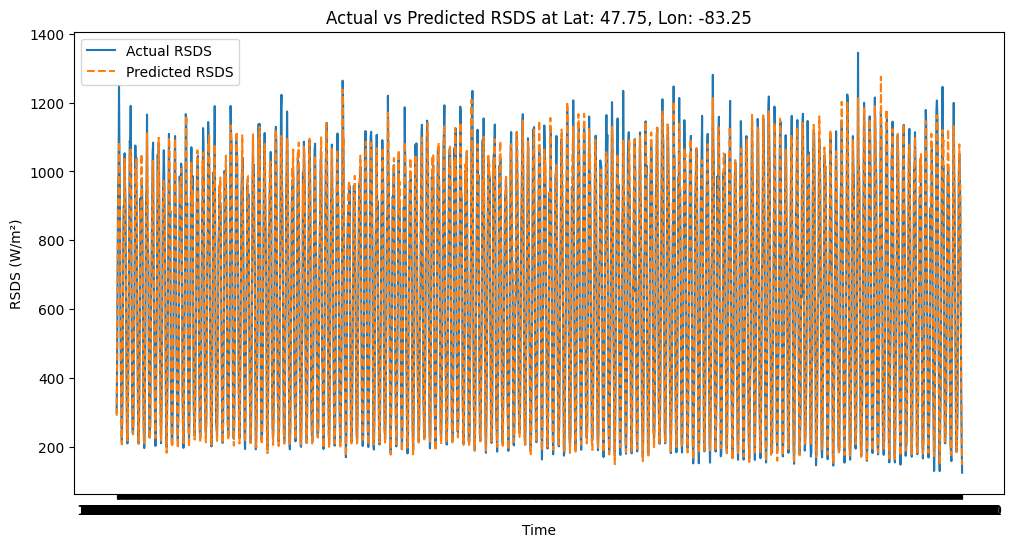

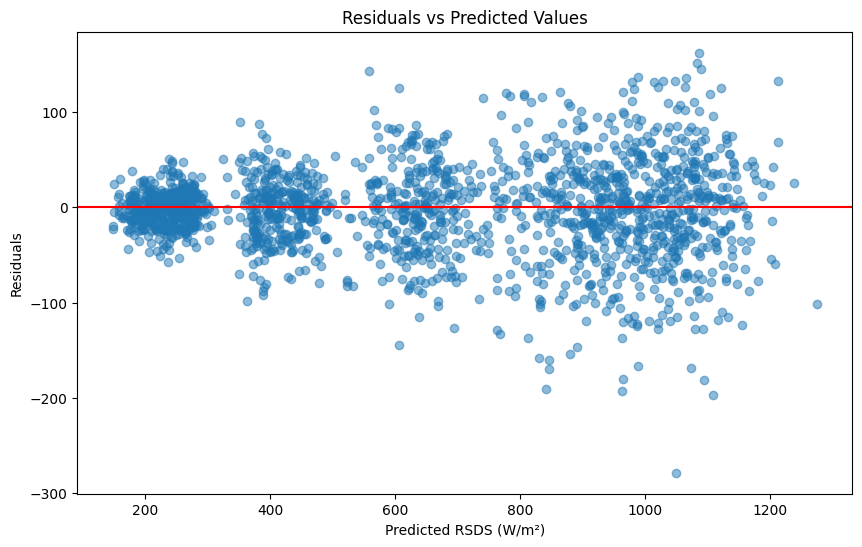

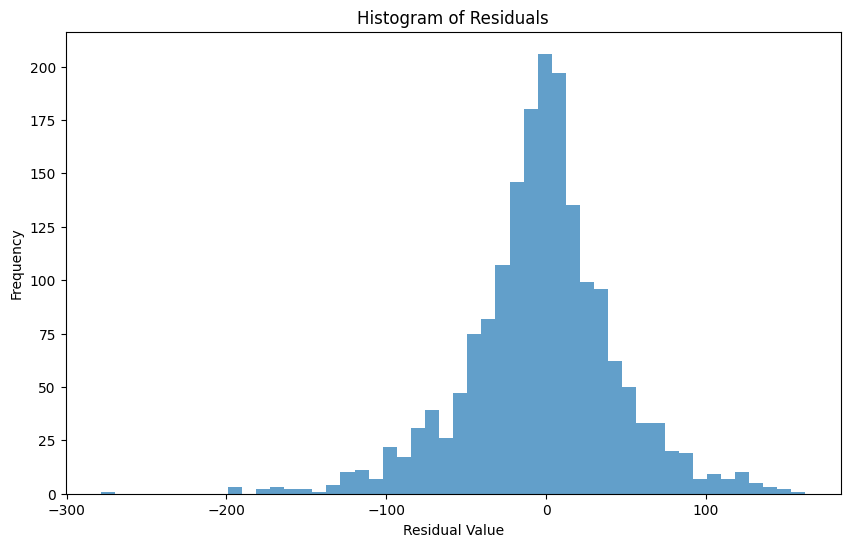

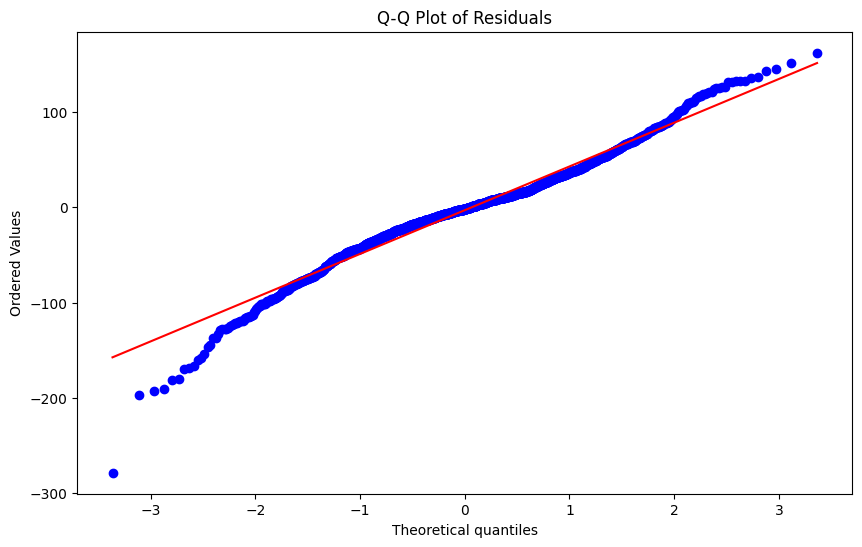

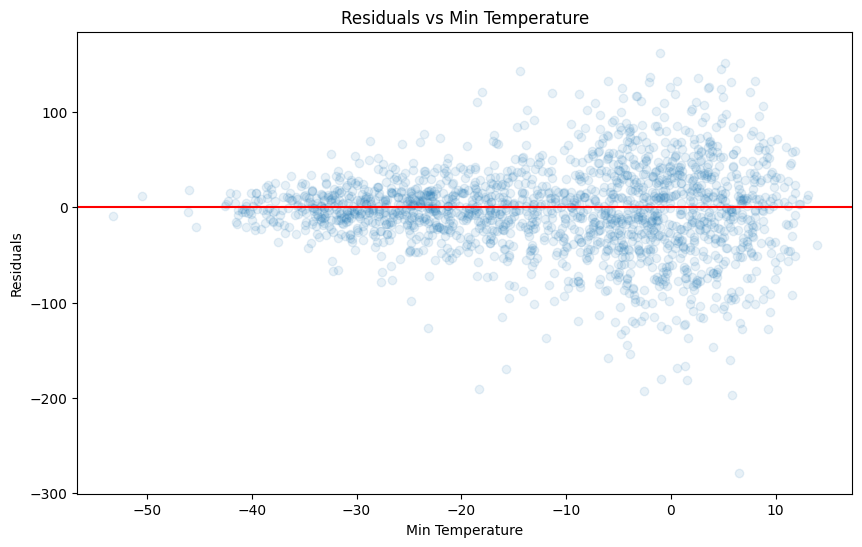

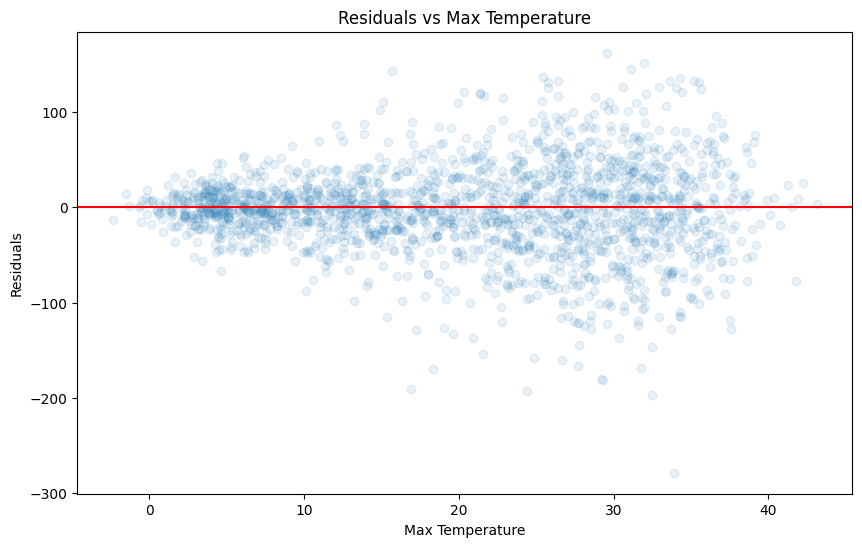

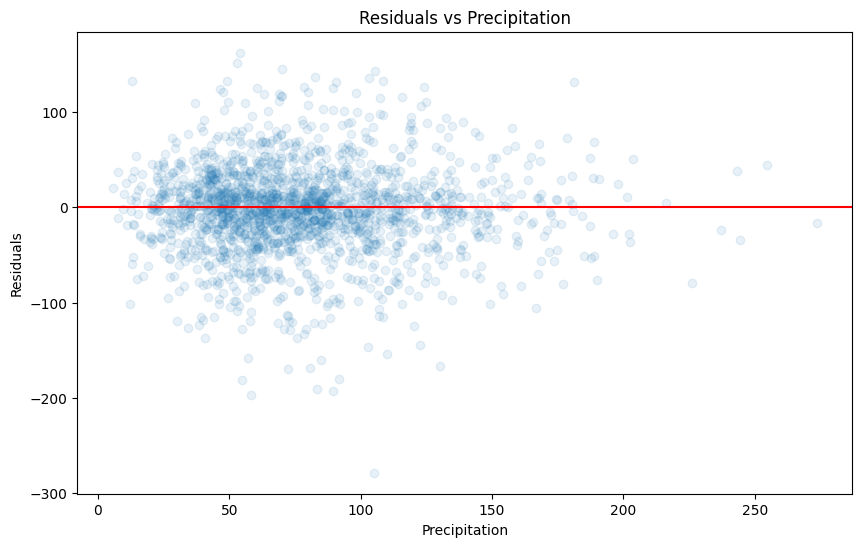

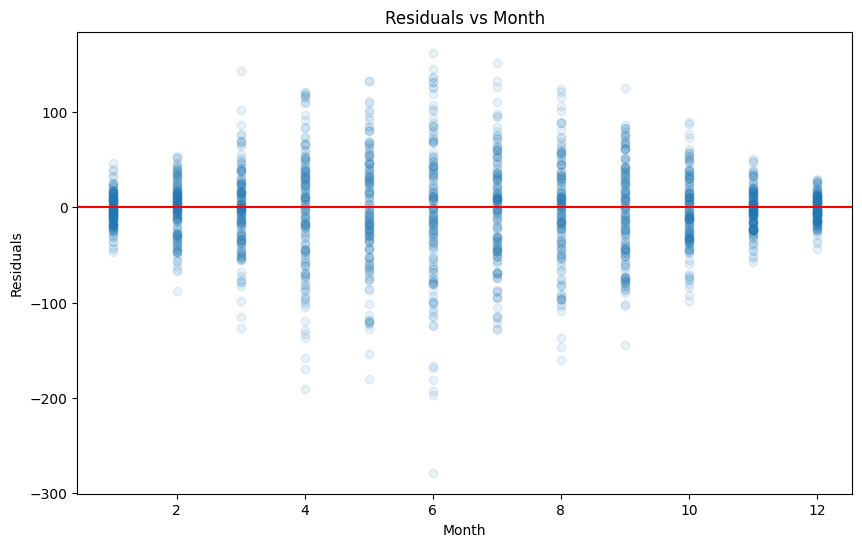

In [10]:
# Second step : Now that we have the data ready to use, we can fit a GAM to predict PAR (rsds) relative to temperature and precipitation and month
# We take the opportunity to create several plots to diagnose the performance of the GAM
from pygam import GAM, s, te, f
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import random
import numpy as np
import os

# Fit GAM model
print("Reading climate data from CanLEADv1")
merged_df = pd.read_csv('ReferencesAndData/dataInputForModel_CanLEADv1.csv')
X = merged_df[['tasminAdjust', 'tasmaxAdjust', 'prAdjust', 'month']]
y = merged_df['rsdsAdjust']

# Define the GAM model
# Here, with interactions : https://r.qcbs.ca/workshop08/book-en/gam-with-interaction-terms.html
# Assuming X is your feature matrix and y is your target variable
# Create weights that emphasize higher values
weights = y / np.mean(y)

# Create a GAM with appropriate terms for periodic data
# This is the best one I got so far in terms of AIC and normal distribution of the residuals.
gam = GAM(
    # Use standard smooth terms with higher n_splines for flexibility
    s(0) +

    # For interaction terms
    te(0, 2) +
    te(1, 2) +
	te(0, 3) +
	te(1, 3) +

    # Add individual smooth terms
    s(1) +
    s(2) +

    # Keep the categorical variable
    f(3),

    distribution='gamma',
    link='log'
)

print("Fitting GAM model...")
# Fit the model with the weights
gam.fit(X, y, weights=weights)

# Print summary
print(gam.summary())

# Make predictions
merged_df['rsds_pred'] = gam.predict(X)

# Calculate R-squared
r_squared = gam.statistics_['pseudo_r2']['explained_deviance']
print(f"R-squared: {r_squared}")

# Plot results for 5 random locations
unique_locations = merged_df[['lat', 'lon']].drop_duplicates().values.tolist()
if len(unique_locations) < 5:
    selected_locations = random.sample(unique_locations, len(unique_locations))
else:
    selected_locations = random.sample(unique_locations, 5)
for i, (lat, lon) in enumerate(selected_locations):
    location_data = merged_df[(merged_df['lat'] == lat) & (merged_df['lon'] == lon)]
    if location_data.empty:
        print(f"No data found for location {lat}, {lon}")
        continue
    plt.figure(figsize=(12, 6))
    plt.plot(location_data['time'], location_data['rsdsAdjust'], label='Actual RSDS')
    plt.plot(location_data['time'], location_data['rsds_pred'], label='Predicted RSDS', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('RSDS (W/m²)')
    plt.title(f'Actual vs Predicted RSDS at Lat: {lat}, Lon: {lon}')
    plt.legend()
    # plt.savefig(f'plots/rsds_prediction_location_{i+1}.png', dpi = 300)
    # plt.close()

# Plot residuals
# Calculate residuals
predictions = gam.predict(X)
residuals = y - predictions
# Create directory for plots if it doesn't exist
if not os.path.exists('plots'):
    os.makedirs('plots')
# Plot 1: Residuals vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted RSDS (W/m²)')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
# plt.savefig('plots/residuals_vs_predicted.png')
# plt.close()
# Plot 2: Histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, alpha=0.7)
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
# plt.savefig('plots/residuals_histogram.png')
# plt.close()
# Plot 3: QQ plot of residuals
plt.figure(figsize=(10, 6))
from scipy import stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
# plt.savefig('plots/residuals_qq_plot.png')
# plt.close()
# Plot 4: Residuals vs each predictor
feature_names = ['Min Temperature', 'Max Temperature', 'Precipitation', 'Month']
for i, feature in enumerate(X.columns):
    plt.figure(figsize=(10, 6))
    plt.scatter(X.iloc[:, i], residuals, alpha=0.1)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel(feature_names[i])
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs {feature_names[i]}')
    # plt.savefig(f'plots/residuals_vs_{feature}.png')
    # plt.close()

Concerning the diagnostic of the GAM : we can see that the predicted values are very close to the observed values. Residuals are overall distributed normally, but are higher for certains months (summer) and for low precipitation/high temperatures (surely a correlation to summer). It makes sense since the values of PAR are much higher and variable in the summer - which results in higher residuals. These tendancies are also observed on larger areas than the one that we are dealing with here.

In [11]:
# Third step : we use the GAM to predict PAR from the temperature and precipitation data that we took from CanDSC-M6 earlier.
# Run the previous cell before running this one

df_climateData = pd.read_csv('ReferencesAndData/dataFrameClimate.csv')
X = df_climateData[['Tmin', 'Tmax', 'SumOfPrecipitations', 'Month']]
df_climateData['PAR_umol/m2/s'] = gam.predict(X) # Careful about the units ! We formatted the input data of the GAM for umol/m2/s, the default unit in PnET
df_climateData.to_csv("ReferencesAndData/dataFrameClimate.csv", sep=',', index=False, encoding='utf-8')

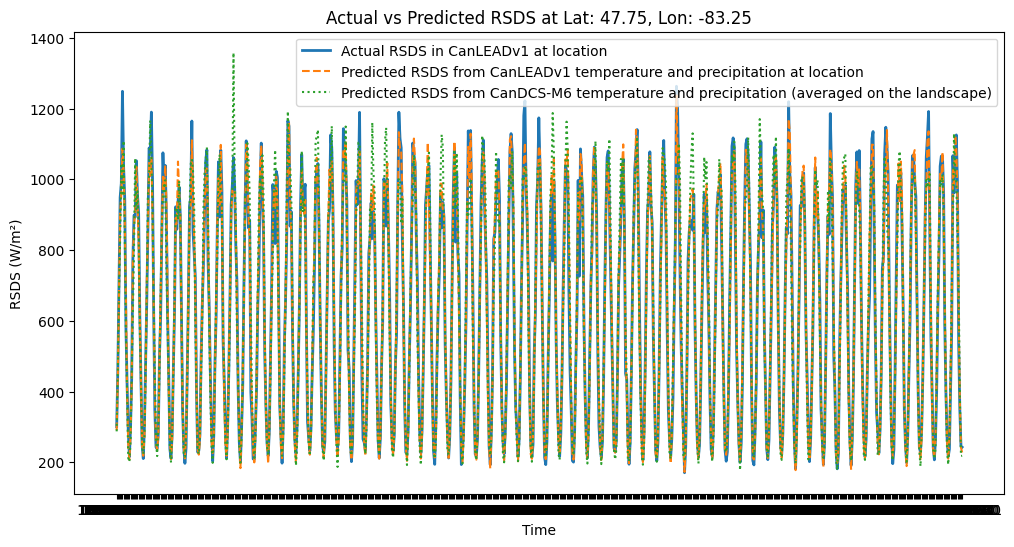

In [12]:
# Outputing a diagnostic plot for the first location in the data of CanLEADv1 versus the average data we've done for CanDSC-M6 data
location = merged_df.iloc[0][['lat', 'lon']]
location_data_CanLEADv1 = merged_df[(merged_df['lat'] == location['lat']) & 
                          (merged_df['lon'] == location['lon'])]
# We add a time column to CanDCS-M6 data
df_climateData["time"] = df_climateData["Year"].astype(str) + "-" + df_climateData["Month"].astype(str) + "-01"

lengthOfData = len(df_climateData['PAR_umol/m2/s'])

plt.figure(figsize=(12, 6))
plt.plot(location_data_CanLEADv1['time'][0:lengthOfData], location_data_CanLEADv1['rsdsAdjust'][0:lengthOfData], label='Actual RSDS in CanLEADv1 at location', linewidth=2)
plt.plot(location_data_CanLEADv1['time'][0:lengthOfData], location_data_CanLEADv1['rsds_pred'][0:lengthOfData], label='Predicted RSDS from CanLEADv1 temperature and precipitation at location', linestyle='--')
# We use the same time data as CanLEADv1, as the measurements are for the exact same months anyway.
plt.plot(location_data_CanLEADv1['time'][0:lengthOfData], df_climateData['PAR_umol/m2/s'], label='Predicted RSDS from CanDCS-M6 temperature and precipitation (averaged on the landscape)', linestyle='dotted')
plt.xlabel('Time')
plt.ylabel('RSDS (W/m²)')
plt.title(f'Actual vs Predicted RSDS at Lat: {location["lat"]}, Lon: {location["lon"]}')
plt.legend()
plt.show()

The predicted values show a really good fit on both CanLEADv1 (the training data) and CanDCS-M6 data. The seasonal variance, along with the year to year variance in the high and lows seem to be conserved really well.

I'm certain that other approaches can be even better, but that will do great for calibration purposes.

As such, we end up with a data frame containing Precipitations, Tmin, Tmax and Par for historical (1950-2010) data, with precipitations, Tmin and Tmax coming from the model closest to the concensus in CanDCS-M6 (see above), and PAR coming from a statistical model trained on CanLEADv1 data.

In [13]:
print(pd.read_csv('ReferencesAndData/dataFrameClimate.csv'))

     Year  Month       Tmax       Tmin  SumOfPrecipitations  PAR_umol/m2/s
0    1950      1  -0.962500 -38.264578            48.433594     287.322029
1    1950      2   1.412500 -40.311453            34.815105     462.168322
2    1950      3   2.433344 -31.837500            45.216145     675.518331
3    1950      4  12.079156 -14.577094            73.825523     832.165611
4    1950      5  27.235406  -6.316656            56.029949    1038.810207
..    ...    ...        ...        ...                  ...            ...
727  2010      8  27.193750   0.964594           106.750000     830.597955
728  2010      9  26.912500  -0.045844            32.690105     693.378541
729  2010     10  21.454156  -5.358344            78.263023     398.584296
730  2010     11  11.443750 -14.202094           111.296875     217.547460
731  2010     12   1.912500 -26.571875            37.022137     218.265022

[732 rows x 6 columns]


### Climate source for ☁️ CO2 concentrations

While there are local variations around the atmosphere in CO2 concentrations (see [here](https://earthobservatory.nasa.gov/images/82142/global-patterns-of-carbon-dioxide)), the differences are small, and it seems like global values can be used (see [here](https://earthobservatory.nasa.gov/blogs/earthmatters/2016/12/05/reader-question-does-co2-disperse-evenly-around-the-earth/)).

Data from https://www.nature.com/articles/s41597-022-01196-7#Sec5 seems very promising : available at https://zenodo.org/records/5021361, not too big, allows for local variations in CO2 concentration. Would need to script the download and treatment of the files here. Timestep is already monthly. Goes to 2150, so perfect for our uses.

Justification for using the dataset :

- We know that this CO2 dataset does not come from the same GCM that generated our climate data, and there could be variability between the variability of climate variables in one dataset versus the climate variables in the models that generated these CO2 estimates at each given timestep.
- However, We thought it better to use this dataset to approximate CO2 spatial and temporal variations in our simulations rather than using latitudinal or global averages. 

In [ ]:
# First, we download the CO2 data from https://zenodo.org/records/5021361 

from functionsForCalibration import *
import pandas as pd
import urllib.request
import subprocess
import os

# We use the zenodo_get library to download files from Zenodo very fast; other methods tend to be slow.
# See https://github.com/dvolgyes/zenodo_get . It is installed in the Docker image.
# WARNING : will take around 1.5GB of space for the data from 1950 to 2150 for a full climate scenario.

# We download the file with historical data
os.system("cd ReferencesAndData && zenodo_get 5021361 -g CO2_1deg_month_1850-2013.nc")

# Then, we download the file with future data
# Not needed here since we're working with historical data only, but can be re-used in the future
# os.system("cd ReferencesAndData && zenodo_get 5021361 -g CO2_SSP126_2015_2150.nc")

# We download the .nc files

# WARNING : Download from Zenodo seems to be relatively slow, even with a good connection. Expect at least 20min of download.
# urllib.request.urlretrieve("https://zenodo.org/records/5021361/files/CO2_1deg_month_1850-2013.nc?download=1",
                           # "./ReferencesAndData/CO2_1deg_month_1850-2013.nc",
                          # reporthook=progress_hook)

# urllib.request.urlretrieve("https://zenodo.org/records/5021361/files/CO2_SSP126_2015_2150.nc?download=1",
                           # "./ReferencesAndData/CO2_SSP126_2015_2150.nc",
                          # reporthook=progress_hook)

In [ ]:
from functionsForCalibration import *

historical_ds = xr.open_dataset("./ReferencesAndData/CO2_1deg_month_1850-2013.nc")
# future_ds = xr.open_dataset("./ReferencesAndData/CO2_SSP126_2015_2150.nc")
# To use the same functions that we used before for temperature and precipitation, we have to standardize the dataset
# Because it uses latitude and longitude as variables rather than coordinates.
# historical_ds = standardize_xarray_dataset(historical_ds)
# future_ds = standardize_xarray_dataset(future_ds)

# We load the dataframe
df_climate = pd.read_csv("./ReferencesAndData/dataFrameClimate.csv")

# Paths to the files
shapefile = "./ReferencesAndData/ChapleauBoundariesClimate.shp"

# historical_ds

In [ ]:
# Process the data and fill the dataframe
# Function is in functionsForCalibration.py
df_climate = process_co2_data(historical_ds, shapefile, df_climate)

# Display the updated dataframe
print(df_climate.head())
print(df_climate.tail())

# Plot CO2 concentration over time
# plt.figure(figsize=(12, 6))
# yearly_avg = df_climate.groupby('Year')['CO2_Concentration'].mean()
# plt.plot(yearly_avg.index, yearly_avg.values)
# plt.title('Average CO2 Concentration Over Time')
# plt.xlabel('Year')
# plt.ylabel('CO2 Concentration (ppm)')
# plt.grid(True)
# plt.savefig('co2_concentration_trend.png')
# plt.show()

# We update the data frame file
df_climate.to_csv("./ReferencesAndData/dataFrameClimate.csv", sep=',', index=False, encoding='utf-8')

# We delete the climate files once it's over to free up space
os.remove("./ReferencesAndData/CO2_1deg_month_1850-2013.nc")
# os.remove("./ReferencesAndData/CO2_SSP126_2015_2150.nc")

### Averaging climate data in constant historical averages

As said at the beginning, [Gustafson and Miranda (2023)](./ReferencesAndData/Gustafson2024PnETUserGuide.pdf) recommends using a constant climate for calibrating (p. 69). Therefore, we are going to transform our climate data from a monthly year-by-year data into 12 values of historical averages for each months.

In [8]:
import pandas as pd

df_climate = pd.read_csv("./ReferencesAndData/dataFrameClimate.csv")

monthly_avg = df_climate.groupby('Month').agg({
    'Tmax': 'mean',
    'Tmin': 'mean',
    'SumOfPrecipitations': 'mean',
    'PAR_umol/m2/s': 'mean',
    'CO2_Concentration' : 'mean'
}).reset_index()

# Add a Year column with the range of years
min_year = df_climate['Year'].min()
max_year = df_climate['Year'].max()
monthly_avg['Year'] = f"{min_year}-{max_year}"

# Reorder columns to match the desired output
monthly_avg = monthly_avg[['Year', 'Month', 'Tmax', 'Tmin', 'PAR_umol/m2/s', 'SumOfPrecipitations', 'CO2_Concentration']]

# Display the result
print(monthly_avg)

# Export to new file
monthly_avg.to_csv("./ReferencesAndData/dataFrameClimate_historicalAverage.csv", sep=',', index=False, encoding='utf-8')

         Year  Month       Tmax       Tmin  PAR_umol/m2/s  \
0   1950-2010      1   0.737464 -36.896498     271.636886   
1   1950-2010      2   3.655669 -35.664175     447.422742   
2   1950-2010      3  10.778963 -30.476673     666.168402   
3   1950-2010      4  19.205361 -17.522951     886.976261   
4   1950-2010      5  27.262398  -5.332206    1016.673341   
5   1950-2010      6  29.237466  -0.112261    1036.693091   
6   1950-2010      7  29.977732   3.811920    1035.283419   
7   1950-2010      8  28.259153   2.469024     878.605910   
8   1950-2010      9  25.260178  -2.407344     601.087783   
9   1950-2010     10  20.470730  -7.518171     393.313548   
10  1950-2010     11  10.695115 -19.211901     237.569868   
11  1950-2010     12   3.242077 -31.874726     208.661801   

    SumOfPrecipitations  CO2_Concentration  
0             73.912942         347.781625  
1             58.297990         348.370057  
2             64.171854         348.695298  
3             58.614002   

## Soils

Review what SILO means, if it's a good match for "average soils with good water retention" in Ontario (as that's what Gustafson uses). Try different types of soil ?

What soil to use for the calibration process ?

Gustafon recommands SILO (Silty Loam/Silt Loam) soil from the default PnET Succession SaxtonAndRawls file (`C:\Program Files\LANDIS-II-v7\extensions\Defaults\SaxtonAndRawlsParameters.txt`) as a soil that retains water well. This is because the first calibration step should use an "ideal soil" where water is well-retained so that lack of water (or watterlogging) does not influence growth at this calibration step.

However, I wanted to prepare us to generate soils map for Canada, and wanted to see if SILO was a common type of soil in Ontario (since we're going to use FVS Ontario as a reference for the first step of the calibration; see [5.Obtaining_Growth_data_from_FVS.ipynb](./5.Obtaining_Growth_data_from_FVS.ipynb).

We can use the [Soil Landscape Grids of Canada at 100m resolution](https://sis.agr.gc.ca/cansis/nsdb/psm/index.html), which give us info of the % of Sand, Clay and Silt and also the percentage of organic carbon accross the entirety of Canada. Using a simple algorithm, we can reclassify these values into soils types used by PnET Succession (since they are defined by sand, clay and organic matter proportions, among others).

However, this Canadian dataset has rasters for different depths of soil (e.g. 0-5cm, 5-15cm, etc.) up to 100cm. I wanted to average the % of sand and clay accross these depths by weighting the important of each layer to its depth (more depth = more importance in the weighted average). Yet, if I do this with the rasters for the 60-100cm depth, most resulting soils are identified as "bedrock" (BEDR), which makes perfect sense. But I'm note sure it's pertinent to go beyond 60cm if we truly wanna know how soils retain water, especially because BEDR has no water holding capacity in PnET.

Brian Sturtevant told me through personal communications that PnET Succession simulates soil processes down to 100cm of soil - and nothing after that. He refered me to this article that says :

> A maximum rooting zone depth parameter (RootingDepth) defines the depth of the “bucket” and soil texture determines the maximum available water capacity of the “bucket,” calculated as the difference between field capacity and wilting point (Saxton and Rawls, 2004). Soil water potential is a function of soil texture, and the volumetric water content resulting from inputs and outputs (Supplementary Figure S1).

As such, it seems that 1) it's useless to go beyond 100cm (which is good, because that's the maximum depth for which we have data) and 2) the soil texture of a given cell should maybe ideally be averaged for the maximum rooting depth ? But we need the bedrock depth to know that. And there's another problem : PnET Succession doesn't seem to let older trees access more, deeper water than younger trees (see pages 21 and 22 of the user guide); the whole "bucket" of the soil is available to all trees. So if we make the "bucket" too deep, then young trees will artificially access too much water; if we make the bucket too shallow, old trees will not be able to access deeper water reserves as these will not be simulated by PnET. **This is big !! Might influence competition and complementation a lot !!**. I asked Matthew if that could be one of the things we modify for PnET.

For now, I've decided to stick with Sand and Clay proportions to define soil textures based to the 13 textures from the SaxtonAndRawls default file of PnET Succession. These textures are the ones that can be found in the "soil texture pyramid", that can be seen [here (chap 4, page 27)](https://www.fao.org/4/a0541e/a0541e.pdf) and at other places; plus a "bedrock" that is a special one with a lot of gravel to simulate bedrock. We could add the % of organic matter latter to the algorithm.

I've also decided to stop at 60cm and not look at the 60-100cm raster. 

At which soil depth to stop ?
Should I include bedrock in the algorithm ? How to detect it properly ? Parameters in SaxtonAndRawl are weird.

- But is it a realistic soil for Ontario or for Canada in general ? => Try to check map of soils

In [1]:
# This script downloads the sand and clay soil texture files for Ontario
# from https://sis.agr.gc.ca/cansis/nsdb/psm/index.html
# (or rather https://agriculture.canada.ca/atlas/data_donnees/griddedSoilsCanada/data_donnees/raster/)
# Silt is not needed, as it's always the rest of the fraction
# It then does the average of % sand and % clay
# on the different soil depth (ponderated by the depth)
# Finally, it creates a raster where each cell contains a code
# corresponding to one of the 12 soil types that are in the 
# SaxtonAndRawls default parameter file for PnET Succession,
# by finding the soil type closest (in euclidian distance on the coordinates of
# % of sand and % of clay) to the one in each cell.
import tarfile
from functionsForCalibration import *

def DownloadAndDecompressSoilsRasterFiles(listOfRastersURLs):
    uncompressedFilesPaths = list()
    for rasterPath in listOfRastersURLs:
        archiveFilePath = "/tmp/" + os.path.basename(rasterPath)
        outputFileName = "/tmp/" + os.path.basename(rasterPath)[0:-6] + "tif"
        if os.path.exists(outputFileName):
            uncompressedFilesPaths.append(outputFileName)
        else:
            if not os.path.exists(archiveFilePath):
                download_file(rasterPath, archiveFilePath)
            with tarfile.open(archiveFilePath, 'r:gz') as tar:
                    tar.extractall(path="/tmp/")
            # We find the name of the extracted .tif file : same as archive name, but with .tif at the end.
            print(outputFileName)
            uncompressedFilesPaths.append(outputFileName)
            os.remove(archiveFilePath)
    return(uncompressedFilesPaths)

# We don't re-run this cell if the final raster already exists, to avoid downloading a lot of data when running the notebook
# WARNING : If you want to re-generate the file, delete it or 
if not os.path.exists("./ReferencesAndData/soilsCodes_SaxtonAndRawls_ON.tif"):
    
    # First : We calculate the average rasters accross the clay rasters
    listOfClayRastersURLs = ["https://agriculture.canada.ca/atlas/data_donnees/griddedSoilsCanada/data_donnees/raster/Clay/Clay_X0_5_cm_100m1980_2000v1_ON.tar.gz",
                         "https://agriculture.canada.ca/atlas/data_donnees/griddedSoilsCanada/data_donnees/raster/Clay/Clay_X5_15_cm_100m1980_2000v1_ON.tar.gz",
                         "https://agriculture.canada.ca/atlas/data_donnees/griddedSoilsCanada/data_donnees/raster/Clay/Clay_X15_30_cm_100m1980_2000v1_ON.tar.gz",
                         "https://agriculture.canada.ca/atlas/data_donnees/griddedSoilsCanada/data_donnees/raster/Clay/Clay_X30_60_cm_100m1980_2000v1_ON.tar.gz",
                         "https://agriculture.canada.ca/atlas/data_donnees/griddedSoilsCanada/data_donnees/raster/Clay/Clay_X60_100_cm_100m1980_2000v1_ON.tar.gz"]
    
    clayRastersPaths = DownloadAndDecompressSoilsRasterFiles(listOfClayRastersURLs)

    # We also give weights to the average that correspond to the deepness of soil for each rasters;
    # 0-5cm for the first one contribute less to the average of the % than the 60-100cm one.
    averageClay, clayMetadata = calculate_raster_average(clayRastersPaths,
                                                        weights = [5, 10, 15, 30, 40])
    
    save_average_raster("/tmp/Clay_Average_0-100_cm_100m1980_2000v1_ON.tif",
                        averageClay, clayMetadata)

    # Same, but with sand rasters
    listOfSandRastersURLs = ["https://agriculture.canada.ca/atlas/data_donnees/griddedSoilsCanada/data_donnees/raster/Sand/Sand_X0_5_cm_100m1980_2000v1_ON.tar.gz",
                         "https://agriculture.canada.ca/atlas/data_donnees/griddedSoilsCanada/data_donnees/raster/Sand/Sand_X5_15_cm_100m1980_2000v1_ON.tar.gz",
                         "https://agriculture.canada.ca/atlas/data_donnees/griddedSoilsCanada/data_donnees/raster/Sand/Sand_X15_30_cm_100m1980_2000v1_ON.tar.gz",
                         "https://agriculture.canada.ca/atlas/data_donnees/griddedSoilsCanada/data_donnees/raster/Sand/Sand_X30_60_cm_100m1980_2000v1_ON.tar.gz",
                         "https://agriculture.canada.ca/atlas/data_donnees/griddedSoilsCanada/data_donnees/raster/Sand/Sand_X60_100_cm_100m1980_2000v1_ON.tar.gz"]
    
    sandRastersPaths = DownloadAndDecompressSoilsRasterFiles(listOfSandRastersURLs)
    
    averageSand, sandMetadata = calculate_raster_average(sandRastersPaths,
                                                        weights = [5, 10, 15, 30, 40])
    
    save_average_raster("/tmp/Sand_Average_0-100_cm_100m1980_2000v1_ON.tif",
                        averageClay, clayMetadata)
    
    # Then, we compute the soil codes raster
    classify_soil_types_chunked(sand_path = "/tmp/Sand_Average_0-100_cm_100m1980_2000v1_ON.tif",
                                clay_path = "/tmp/Clay_Average_0-100_cm_100m1980_2000v1_ON.tif",
                                output_path = "./ReferencesAndData/soilsCodes_SaxtonAndRawls_ON.tif",
                                chunk_size=1024)
    
    # We remove the averaged files now that we're done
    # os.remove("/tmp/Sand_Average_0-100_cm_100m1980_2000v1_ON.tif")
    # os.remove("/tmp/Clay_Average_0-100_cm_100m1980_2000v1_ON.tif")

# END UP BY WRAPPING EVERYTHING IN A IF TO NOT RUN CELL IF RECOMPOSED SOIL RASTER IS ALREADY DONE






Downloaded 320.535 Megabyte(s) in 1:58 minute(s). (2778.51 KB/s)                                    ees/raster/Sand/Sand_X0_5_cm_100m1980_2000v1_ON.tar.gz
/tmp/Sand_X0_5_cm_100m1980_2000v1_ON.tif
Downloaded 316.304 Megabyte(s) in 1:55 minute(s). (2806.68 KB/s)                                    ees/raster/Sand/Sand_X5_15_cm_100m1980_2000v1_ON.tar.gz
/tmp/Sand_X5_15_cm_100m1980_2000v1_ON.tif
Downloaded 317.183 Megabyte(s) in 2:08 minute(s). (2519.04 KB/s)                                    ees/raster/Sand/Sand_X15_30_cm_100m1980_2000v1_ON.tar.gz
/tmp/Sand_X15_30_cm_100m1980_2000v1_ON.tif
Downloaded 317.197 Megabyte(s) in 1:53 minute(s). (2863.03 KB/s)                                    ees/raster/Sand/Sand_X30_60_cm_100m1980_2000v1_ON.tar.gz
/tmp/Sand_X30_60_cm_100m1980_2000v1_ON.tif
Downloaded 314.472 Megabyte(s) in 1:49 minute(s). (2948.46 KB/s)                                    ees/raster/Sand/Sand_X60_100_cm_100m1980_2000v1_ON.tar.gz
/tmp/Sand_X60_100_cm_100m1980_2000v1_ON.tif
Open

USE SILO ANYWAY : the goal is not to use a soil that is prevalent in the area, but rather a soil that is the best to retain water for this first step of the calibration.

## TODO

- Put entire R script with all GAMS tested with AI + Daniel
- Put R script adapted in Python in this page to re-generate PAR value with the better model
- Finish soils (keep talking with Matthew about it + check the methodology of Brian's team in the documents they sent : calibrate first ideal step on SILO as best soil to keep water BUT careful about the amount of water you put in it not to waterlog; then find the H1 H2 H3 H4 parameters; and THEN calibrate the leakage of the soils/the soils of the area, by focusing on the important limiting factors of the area : low porosity/water holding capacity or low bedrock ?)
- Rethink Climate : We will need daily data for BFOLDS fire. So, we better get ready for it right now. Check back what dataset has daily data for several climate scenarios. Check with Ameray to see how they got PAR.
    - Reading back my emails exchanges with the ECCC : CanDCS-M6 is daily, but I've been using their "pre-computed" climate indices that are annual, monthly or seasonal.
    - What do they use for BFOLDS fire in the articles sent by Marc Ouelette ? In [here](https://doi.org/10.1186/s42408-023-00188-1), they used data from a single GCM, but had to mix data from two different dataset in order to get daily PAR values. They do talk about the portal they used, which seem very interesting. It seems that some of the data on it might be accessible in the form of THREDDS servers, which might allows for a pretty quick use of the data. But you gotta use a node that is active (see "Node" tab) and there seem to be so many files that it's going to be complex....It feels like we're back to square on.
        - Looks like BFOLDs fire needs a couple of other variables than PnET to work; in particular, humidity of the air, U- and V-wind inputs.
        - Might be that the climate data used [here](https://doi.org/10.1186/s42408-023-00188-1) is much coarser than CanDCS-M6, but there are much more variables. I think that this might be much better, because I'm not sure if we need a lot of spatial climate resolution in our landscapes ? Better have all of the variables together in one dataset and avoid going through GAMs and all.
        - By using the node https://esgf.nci.org.au (one of the nodes that allow access to ESGF climate data), it's a bit overwelming at first. There are millions of search results, even by searching for a very specific search pattern like "CESM2 WACCM Shortwave radiation SSP5". It's better to use the filters on the left of the screen to filter : Source ID (e.g. CESM2-WACCM as in [here](https://doi.org/10.1186/s42408-023-00188-1), used because it has PAR, or rather rsds/Downwelling shortwave radiation); Experiment ID (e.g. SSP585, climate scenario; historical is available); Resolution (100km is the highest rez available); Variant label (e.g. r1i1p1f1, which is an ID for the replicate and forcing conditions for the model run; r1i1p1f1 seems to be the most used, might be the default. Will take this one going forward for now, but we might use replicates to have some variability in the fire conditions ?); frequency (here, day); Variable ID (here, these are the variable ID names also used in CanDCS-M6; tasmax for max temp, tn, etc. can also use CF standard name to select the variable in a more explicit way. If you've selected all of the previous filters, you will have the variables necessary for PnET : tasmax, tasmin (Daily Minimum Near-Surface Air Temperature), rsds (PAR or Downwelling Shortwave Radiation), pr (precipitations); but also those necessary for BFOLDs Fire, with specific humidity (hus or huss; huss seems better as it seems to be near surface) and wind speed + wind directions east and north (which can easily be transformed into the wind directions necessary for BFOLDS fire).
            - If one uses all of thse filters, for exemple for rsds (PAR), one ends up with 4 files only to choose from (see [here](https://esgf.nci.org.au/search?project=CMIP6&activeFacets=%7B%22source_id%22%3A%22CESM2-WACCM%22%2C%22experiment_id%22%3A%22ssp585%22%2C%22nominal_resolution%22%3A%22100+km%22%2C%22variant_label%22%3A%22r1i1p1f1%22%2C%22frequency%22%3A%22day%22%2C%22variable_id%22%3A%22rsds%22%7D)) !
                 - The files are in .nc format, accessible through a THREDD catalog (so, should be able to use the previous scripts).
                 - Some of the records seem to be exactly the same (same checksum); I don't know why they are replicated. Creator and everything else seem to be the same. Some are accessible through different protocols; only difference seems to be in the data node. One record has less files. The .nc files are for data periods; the dates are indicated in the name (e.g. 20150101-20241231 => 01-01-2015 to 31-12-2024). So, it's just a question of looping on the files and getting the data we need.
                 - We will use the historical data here, available [here](https://esgf.nci.org.au/search?project=CMIP6&activeFacets=%7B%22source_id%22%3A%22CESM2-WACCM%22%2C%22nominal_resolution%22%3A%22100+km%22%2C%22variant_label%22%3A%22r1i1p1f1%22%2C%22frequency%22%3A%22day%22%2C%22variable_id%22%3A%22rsds%22%2C%22experiment_id%22%3A%22historical%22%7D).
            - What is the ESGF : The Earth System Grid Federation (ESGF) is a collaborative international network of data servers that archives and distributes a vast collection of Earth system model outputs for climate and environmental scientists globally. It serves as a distributed system that links climate centers and users to models and data via a computing grid powered by supercomputing resources and the internet.
        - In the end, I went with a different climate model, as CESM2-WACCM still had the issue of not having min/max daily temperature data, which would require combining its results with those from another GCM to get all of our variables (see appendice of [here](https://doi.org/10.1186/s42408-023-00188-1) for an example).
            - There are many available on the ESGF. I first looked at those who seemed to have all of our variables (tasmin, tasmax, prc and rsds in the filters) and that where also used in the CanDCS-M6 ensemble that I used before. Then, I looked one by one in the EGSF database if we could truly get all variables for each model, for historical and for all SSP climate scenarios.
                - Almost all models selected this way (8 in total) had all of the variables we needed for historical conditions and for all 4 biggest SSP scenarios. Not all of them had replicates available; but then, we could use different GCMs as replicates.
                - I chose to go with TaiESM1, as it was the closest to the median for the temperature and precipitations for our first tests with the CanDCS-M6 dataset (see drafts ?). According to the litterature, it also seems to have a pretty good performance overall when compared in GCM ensembles (see [here](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020MS002353)). But EC-Earth3-CC (see [here](https://www.nrel.gov/docs/fy24osti/90166.pdf)) seem to have better metrics (lower error) for precipitations and temperatures compared to TaiESM1. But it doesn't have data for all SSPs, so I'll go with TaiESM1 for now.

In [1]:
from functionsForCalibration import *
from intake_esgf import ESGFCatalog
import intake_esgf

# print("Version of intake_esgf is " + str(intake_esgf.__version__))

# # Look in additional nodes, just in case
# intake_esgf.conf.set(indices={"esgf-node.llnl.gov": True,
#                               "esgf-node.ornl.gov": True,
#                               "esgf.ceda.ac.uk": True})
# intake_esgf.conf.set(all_indices=True) 

# Initialize catalog
cat = ESGFCatalog()

# Search for the four variables we need, historical scenario, daily frequency, and the GCM (TaiESM1)
# we want
# If we do this search in the Metagrid, we find the datasets (.gn ?) available on different nodes,
# and with many .nc files in them corresponding to different time periods.
# See https://esgf.nci.org.au/search?project=CMIP6&activeFacets=%7B%22frequency%22%3A%22day%22%2C%22nominal_resolution%22%3A%22100+km%22%2C%22variable_id%22%3A%5B%22rsds%22%2C%22tasmax%22%2C%22tasmin%22%2C%22prc%22%5D%2C%22source_id%22%3A%22TaiESM1%22%2C%22experiment_id%22%3A%22historical%22%2C%22data_node%22%3A%22esgf.ceda.ac.uk%22%7D for an example.
cat.search(
    experiment_id="historical",
    source_id="TaiESM1",
    frequency="day",
    # variable_id=["rsds", "prc", "tasmin", "tasmax", "hur", "ua", "va"], # Variables for BFOLDS added
    variable_id=["rsds", "prc", "tasmin", "tasmax"]
    # variable_id=["prc"]
)

# Printing shows 4 catalogs/datasets; corresponding to the .gn files one
# can see on the Metagrid ? If so, each should contain a lot of different .nc files
# for different time periods
# print(cat.df)

# Making a dictionnary with the path to then access the data in xarray with OpenDAP,
# we can see that the function only return one single .nc file per dataset, for a single
# time period. The time period for each variable seems to be pretty random.
paths = cat.to_path_dict(prefer_streaming=True)
# print(paths)

   Searching indices:   0%|          |0/2 [       ?index/s]

Get file information:   0%|          |0/2 [       ?index/s]

In [2]:
from functionsForCalibration import *

dictOfDataFrames = dict()

for variable in paths.keys():
    variableInitialized = False
    for path in paths[variable]:
        if not variableInitialized:
            dictOfDataFrames[variable] = GetDataFromESGFdataset(path,
                                            yearStart = 1950,
                                            yearStop = 2010,
                                            pathOfShapefileForSubsetting = "./ReferencesAndData/ChapleauBoundariesClimate.shp",
                                            nameOfVariable = variable,
                                            enableWarnings = False)
            variableInitialized = True
        else:
            dictOfDataFrames[variable] = pd.concat([dictOfDataFrames[variable], GetDataFromESGFdataset(path,
                                            yearStart = 1950,
                                            yearStop = 2010,
                                            pathOfShapefileForSubsetting = "./ReferencesAndData/ChapleauBoundariesClimate.shp",
                                            nameOfVariable = variable,
                                            enableWarnings = False)], ignore_index=True)
        # We sort the values by day, because they might be out of order.
        dictOfDataFrames[variable] = dictOfDataFrames[variable].sort_values(['year', 'month', 'day'])
        # print(dictOfDataFrames[variable])

Processing rsds_day_TaiESM1_historical_r1i1p1f1_gn_19700101-19791231.nc...
Processing rsds_day_TaiESM1_historical_r1i1p1f1_gn_19800101-19891231.nc...
Processing rsds_day_TaiESM1_historical_r1i1p1f1_gn_19100101-19191231.nc...
Cancelling; dataset is before 1950 or after 2010
Processing rsds_day_TaiESM1_historical_r1i1p1f1_gn_19200101-19291231.nc...


/tmp/ipykernel_1372/2717417056.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dictOfDataFrames[variable] = pd.concat([dictOfDataFrames[variable], GetDataFromESGFdataset(path,


Cancelling; dataset is before 1950 or after 2010
Processing rsds_day_TaiESM1_historical_r1i1p1f1_gn_19300101-19391231.nc...


/tmp/ipykernel_1372/2717417056.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dictOfDataFrames[variable] = pd.concat([dictOfDataFrames[variable], GetDataFromESGFdataset(path,


Cancelling; dataset is before 1950 or after 2010
Processing rsds_day_TaiESM1_historical_r1i1p1f1_gn_19500101-19591231.nc...


/tmp/ipykernel_1372/2717417056.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dictOfDataFrames[variable] = pd.concat([dictOfDataFrames[variable], GetDataFromESGFdataset(path,


Processing rsds_day_TaiESM1_historical_r1i1p1f1_gn_19600101-19691231.nc...
Processing rsds_day_TaiESM1_historical_r1i1p1f1_gn_20100101-20141231.nc...
Processing rsds_day_TaiESM1_historical_r1i1p1f1_gn_18500101-18591231.nc...
Cancelling; dataset is before 1950 or after 2010
Processing rsds_day_TaiESM1_historical_r1i1p1f1_gn_18800101-18891231.nc...


/tmp/ipykernel_1372/2717417056.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dictOfDataFrames[variable] = pd.concat([dictOfDataFrames[variable], GetDataFromESGFdataset(path,


Cancelling; dataset is before 1950 or after 2010
Processing rsds_day_TaiESM1_historical_r1i1p1f1_gn_18900101-18991231.nc...


/tmp/ipykernel_1372/2717417056.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dictOfDataFrames[variable] = pd.concat([dictOfDataFrames[variable], GetDataFromESGFdataset(path,


Cancelling; dataset is before 1950 or after 2010
Processing rsds_day_TaiESM1_historical_r1i1p1f1_gn_19400101-19491231.nc...


/tmp/ipykernel_1372/2717417056.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dictOfDataFrames[variable] = pd.concat([dictOfDataFrames[variable], GetDataFromESGFdataset(path,


Cancelling; dataset is before 1950 or after 2010
Processing rsds_day_TaiESM1_historical_r1i1p1f1_gn_20000101-20091231.nc...


/tmp/ipykernel_1372/2717417056.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dictOfDataFrames[variable] = pd.concat([dictOfDataFrames[variable], GetDataFromESGFdataset(path,


Processing rsds_day_TaiESM1_historical_r1i1p1f1_gn_18700101-18791231.nc...
Cancelling; dataset is before 1950 or after 2010
Processing rsds_day_TaiESM1_historical_r1i1p1f1_gn_18600101-18691231.nc...


/tmp/ipykernel_1372/2717417056.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dictOfDataFrames[variable] = pd.concat([dictOfDataFrames[variable], GetDataFromESGFdataset(path,


Cancelling; dataset is before 1950 or after 2010
Processing rsds_day_TaiESM1_historical_r1i1p1f1_gn_19900101-19991231.nc...


/tmp/ipykernel_1372/2717417056.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dictOfDataFrames[variable] = pd.concat([dictOfDataFrames[variable], GetDataFromESGFdataset(path,


Processing rsds_day_TaiESM1_historical_r1i1p1f1_gn_19000101-19091231.nc...
Cancelling; dataset is before 1950 or after 2010
Processing tasmin_day_TaiESM1_historical_r1i1p1f1_gn_19400101-19491231.nc...


/tmp/ipykernel_1372/2717417056.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dictOfDataFrames[variable] = pd.concat([dictOfDataFrames[variable], GetDataFromESGFdataset(path,


Cancelling; dataset is before 1950 or after 2010
Processing tasmin_day_TaiESM1_historical_r1i1p1f1_gn_20000101-20091231.nc...


/tmp/ipykernel_1372/2717417056.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dictOfDataFrames[variable] = pd.concat([dictOfDataFrames[variable], GetDataFromESGFdataset(path,


Processing tasmin_day_TaiESM1_historical_r1i1p1f1_gn_18600101-18691231.nc...
Cancelling; dataset is before 1950 or after 2010
Processing tasmin_day_TaiESM1_historical_r1i1p1f1_gn_18900101-18991231.nc...


/tmp/ipykernel_1372/2717417056.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dictOfDataFrames[variable] = pd.concat([dictOfDataFrames[variable], GetDataFromESGFdataset(path,


Cancelling; dataset is before 1950 or after 2010
Processing tasmin_day_TaiESM1_historical_r1i1p1f1_gn_19100101-19191231.nc...


/tmp/ipykernel_1372/2717417056.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dictOfDataFrames[variable] = pd.concat([dictOfDataFrames[variable], GetDataFromESGFdataset(path,


Cancelling; dataset is before 1950 or after 2010
Processing tasmin_day_TaiESM1_historical_r1i1p1f1_gn_19200101-19291231.nc...


/tmp/ipykernel_1372/2717417056.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dictOfDataFrames[variable] = pd.concat([dictOfDataFrames[variable], GetDataFromESGFdataset(path,


Cancelling; dataset is before 1950 or after 2010
Processing tasmin_day_TaiESM1_historical_r1i1p1f1_gn_19500101-19591231.nc...


/tmp/ipykernel_1372/2717417056.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dictOfDataFrames[variable] = pd.concat([dictOfDataFrames[variable], GetDataFromESGFdataset(path,


Processing tasmin_day_TaiESM1_historical_r1i1p1f1_gn_19800101-19891231.nc...
Processing tasmin_day_TaiESM1_historical_r1i1p1f1_gn_18800101-18891231.nc...
Cancelling; dataset is before 1950 or after 2010
Processing tasmin_day_TaiESM1_historical_r1i1p1f1_gn_19900101-19991231.nc...


/tmp/ipykernel_1372/2717417056.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dictOfDataFrames[variable] = pd.concat([dictOfDataFrames[variable], GetDataFromESGFdataset(path,


Processing tasmin_day_TaiESM1_historical_r1i1p1f1_gn_18700101-18791231.nc...
Cancelling; dataset is before 1950 or after 2010
Processing tasmin_day_TaiESM1_historical_r1i1p1f1_gn_19000101-19091231.nc...


/tmp/ipykernel_1372/2717417056.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dictOfDataFrames[variable] = pd.concat([dictOfDataFrames[variable], GetDataFromESGFdataset(path,


Cancelling; dataset is before 1950 or after 2010
Processing tasmin_day_TaiESM1_historical_r1i1p1f1_gn_19300101-19391231.nc...


/tmp/ipykernel_1372/2717417056.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dictOfDataFrames[variable] = pd.concat([dictOfDataFrames[variable], GetDataFromESGFdataset(path,


Cancelling; dataset is before 1950 or after 2010
Processing tasmin_day_TaiESM1_historical_r1i1p1f1_gn_18500101-18591231.nc...


/tmp/ipykernel_1372/2717417056.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dictOfDataFrames[variable] = pd.concat([dictOfDataFrames[variable], GetDataFromESGFdataset(path,


Cancelling; dataset is before 1950 or after 2010
Processing tasmin_day_TaiESM1_historical_r1i1p1f1_gn_20100101-20141231.nc...


/tmp/ipykernel_1372/2717417056.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dictOfDataFrames[variable] = pd.concat([dictOfDataFrames[variable], GetDataFromESGFdataset(path,


Processing tasmin_day_TaiESM1_historical_r1i1p1f1_gn_19600101-19691231.nc...
Processing tasmin_day_TaiESM1_historical_r1i1p1f1_gn_19700101-19791231.nc...
Processing prc_day_TaiESM1_historical_r1i1p1f1_gn_19000101-19091231.nc...
Cancelling; dataset is before 1950 or after 2010
Processing prc_day_TaiESM1_historical_r1i1p1f1_gn_19200101-19291231.nc...
Cancelling; dataset is before 1950 or after 2010
Processing prc_day_TaiESM1_historical_r1i1p1f1_gn_19500101-19591231.nc...


/tmp/ipykernel_1372/2717417056.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dictOfDataFrames[variable] = pd.concat([dictOfDataFrames[variable], GetDataFromESGFdataset(path,


Processing prc_day_TaiESM1_historical_r1i1p1f1_gn_18700101-18791231.nc...
Cancelling; dataset is before 1950 or after 2010
Processing prc_day_TaiESM1_historical_r1i1p1f1_gn_19700101-19791231.nc...


/tmp/ipykernel_1372/2717417056.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dictOfDataFrames[variable] = pd.concat([dictOfDataFrames[variable], GetDataFromESGFdataset(path,


Processing prc_day_TaiESM1_historical_r1i1p1f1_gn_19100101-19191231.nc...
Cancelling; dataset is before 1950 or after 2010
Processing prc_day_TaiESM1_historical_r1i1p1f1_gn_20000101-20091231.nc...


/tmp/ipykernel_1372/2717417056.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dictOfDataFrames[variable] = pd.concat([dictOfDataFrames[variable], GetDataFromESGFdataset(path,


Processing prc_day_TaiESM1_historical_r1i1p1f1_gn_20100101-20141231.nc...
Processing prc_day_TaiESM1_historical_r1i1p1f1_gn_18500101-18591231.nc...
Cancelling; dataset is before 1950 or after 2010
Processing prc_day_TaiESM1_historical_r1i1p1f1_gn_19300101-19391231.nc...


/tmp/ipykernel_1372/2717417056.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dictOfDataFrames[variable] = pd.concat([dictOfDataFrames[variable], GetDataFromESGFdataset(path,


Cancelling; dataset is before 1950 or after 2010
Processing prc_day_TaiESM1_historical_r1i1p1f1_gn_19600101-19691231.nc...


/tmp/ipykernel_1372/2717417056.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dictOfDataFrames[variable] = pd.concat([dictOfDataFrames[variable], GetDataFromESGFdataset(path,


Processing prc_day_TaiESM1_historical_r1i1p1f1_gn_19900101-19991231.nc...
Processing prc_day_TaiESM1_historical_r1i1p1f1_gn_18600101-18691231.nc...
Cancelling; dataset is before 1950 or after 2010
Processing prc_day_TaiESM1_historical_r1i1p1f1_gn_18800101-18891231.nc...


/tmp/ipykernel_1372/2717417056.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dictOfDataFrames[variable] = pd.concat([dictOfDataFrames[variable], GetDataFromESGFdataset(path,


Cancelling; dataset is before 1950 or after 2010
Processing prc_day_TaiESM1_historical_r1i1p1f1_gn_19400101-19491231.nc...


/tmp/ipykernel_1372/2717417056.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dictOfDataFrames[variable] = pd.concat([dictOfDataFrames[variable], GetDataFromESGFdataset(path,


Cancelling; dataset is before 1950 or after 2010
Processing prc_day_TaiESM1_historical_r1i1p1f1_gn_19800101-19891231.nc...


/tmp/ipykernel_1372/2717417056.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dictOfDataFrames[variable] = pd.concat([dictOfDataFrames[variable], GetDataFromESGFdataset(path,


Processing prc_day_TaiESM1_historical_r1i1p1f1_gn_18900101-18991231.nc...
Cancelling; dataset is before 1950 or after 2010
Processing tasmax_day_TaiESM1_historical_r1i1p1f1_gn_18600101-18691231.nc...


/tmp/ipykernel_1372/2717417056.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dictOfDataFrames[variable] = pd.concat([dictOfDataFrames[variable], GetDataFromESGFdataset(path,


Cancelling; dataset is before 1950 or after 2010
Processing tasmax_day_TaiESM1_historical_r1i1p1f1_gn_19100101-19191231.nc...
Cancelling; dataset is before 1950 or after 2010
Processing tasmax_day_TaiESM1_historical_r1i1p1f1_gn_18700101-18791231.nc...
Cancelling; dataset is before 1950 or after 2010
Processing tasmax_day_TaiESM1_historical_r1i1p1f1_gn_19000101-19091231.nc...
Cancelling; dataset is before 1950 or after 2010
Processing tasmax_day_TaiESM1_historical_r1i1p1f1_gn_19200101-19291231.nc...
Cancelling; dataset is before 1950 or after 2010
Processing tasmax_day_TaiESM1_historical_r1i1p1f1_gn_20000101-20091231.nc...


/tmp/ipykernel_1372/2717417056.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dictOfDataFrames[variable] = pd.concat([dictOfDataFrames[variable], GetDataFromESGFdataset(path,


Processing tasmax_day_TaiESM1_historical_r1i1p1f1_gn_18900101-18991231.nc...
Cancelling; dataset is before 1950 or after 2010
Processing tasmax_day_TaiESM1_historical_r1i1p1f1_gn_18800101-18891231.nc...


/tmp/ipykernel_1372/2717417056.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dictOfDataFrames[variable] = pd.concat([dictOfDataFrames[variable], GetDataFromESGFdataset(path,


Cancelling; dataset is before 1950 or after 2010
Processing tasmax_day_TaiESM1_historical_r1i1p1f1_gn_19500101-19591231.nc...


/tmp/ipykernel_1372/2717417056.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dictOfDataFrames[variable] = pd.concat([dictOfDataFrames[variable], GetDataFromESGFdataset(path,


Processing tasmax_day_TaiESM1_historical_r1i1p1f1_gn_19600101-19691231.nc...
Processing tasmax_day_TaiESM1_historical_r1i1p1f1_gn_18500101-18591231.nc...
Cancelling; dataset is before 1950 or after 2010
Processing tasmax_day_TaiESM1_historical_r1i1p1f1_gn_19300101-19391231.nc...


/tmp/ipykernel_1372/2717417056.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dictOfDataFrames[variable] = pd.concat([dictOfDataFrames[variable], GetDataFromESGFdataset(path,


Cancelling; dataset is before 1950 or after 2010
Processing tasmax_day_TaiESM1_historical_r1i1p1f1_gn_19700101-19791231.nc...


/tmp/ipykernel_1372/2717417056.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dictOfDataFrames[variable] = pd.concat([dictOfDataFrames[variable], GetDataFromESGFdataset(path,


Processing tasmax_day_TaiESM1_historical_r1i1p1f1_gn_19900101-19991231.nc...
Processing tasmax_day_TaiESM1_historical_r1i1p1f1_gn_19400101-19491231.nc...
Cancelling; dataset is before 1950 or after 2010
Processing tasmax_day_TaiESM1_historical_r1i1p1f1_gn_19800101-19891231.nc...


/tmp/ipykernel_1372/2717417056.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dictOfDataFrames[variable] = pd.concat([dictOfDataFrames[variable], GetDataFromESGFdataset(path,


Processing tasmax_day_TaiESM1_historical_r1i1p1f1_gn_20100101-20141231.nc...


In [ ]:
# Now that we have the raw data accross several 100x100km grid cells for all variables necessary for PnET,
# we simply have to transform the measures if needed (e.g. PAR into umol/m2.s for the right radiation range instead of rsds which is W/m2)
# and then put everything in the right format for the LANDIS-II v8 climate library, and finally output things as .csv
# for latter use
import copy

# First, we restrict our data to only one climate cell, since we will only simulate on cell in our monocultures
# We get the unique coordinates in the dataframe
uniqueCoordinatesInDataFrames = extract_unique_coordinates(dictOfDataFrames["rsds"])
# Then, we choose the cell that is closest to the centroid of our chapleau region we've been using
bestCoordinatePair = find_closest_coordinate_to_polygon_center("./ReferencesAndData/ChapleauBoundariesClimate.shp",
                                                                uniqueCoordinatesInDataFrames)
# Then, we remove all references to other coordinate pairs
# Extract the latitude and longitude from the target coordinate
target_lat, target_lon = bestCoordinatePair
dictOfDataFramesSubset = copy.deepcopy(dictOfDataFrames)
for variable in dictOfDataFramesSubset.keys():
    # Create a mask for rows matching the target coordinate
    mask = (dictOfDataFramesSubset[variable]['lat'] == target_lat) & (dictOfDataFramesSubset[variable]['lon'] == target_lon)
    dictOfDataFramesSubset[variable] = dictOfDataFramesSubset[variable][mask]

# Now, we put all dataframes together in a single dataframe
mergedDataframe = pd.merge(dictOfDataFramesSubset["rsds"], dictOfDataFramesSubset["prc"], on = ["lat", "lon", "year", "month", "day"], how='left')
mergedDataframe = pd.merge(mergedDataframe, dictOfDataFramesSubset["tasmax"], on = ["lat", "lon", "year", "month", "day"], how='left')
mergedDataframe = pd.merge(mergedDataframe, dictOfDataFramesSubset["tasmin"], on = ["lat", "lon", "year", "month", "day"], how='left')

# WARNING : prc values are often 0. It's because it's daily precipitation data, it's normal !
# print(mergedDataframe)

##################################
# Transforming units (important !)
# And also variable names, to fit what is needed for the
# LANDIS-II v8 climate library
##################################

# tasmin and tasmax are in kelvin. We put then in celcius.
mergedDataframe['Tmin'] = mergedDataframe['tasmin'].apply(kelvin_to_celsius)
mergedDataframe['Tmax'] = mergedDataframe['tasmax'].apply(kelvin_to_celsius)

# Precipitations are in kg m-2 s-1 (see ESGF metagrid metadata for validation : https://esgf.nci.org.au/search?project=CMIP6&activeFacets=%7B%22nominal_resolution%22%3A%22100+km%22%2C%22frequency%22%3A%22day%22%2C%22experiment_id%22%3A%22historical%22%2C%22source_id%22%3A%22TaiESM1%22%2C%22variable_id%22%3A%22prc%22%7D)
# Transforming precipitations from their original unit - kg m-2 s-1 - into cm per day
mergedDataframe['precip'] = mergedDataframe['prc']*8640 # Going from seconds to days (86400 seconds in a day) and from mm (kg m-2) into cm (/10)

# Transforming downwelling shortwave radiation from W/m2 to umol.m2/s-1
# Based on the PnET User Guide's instructions
# Downwelling shortwave radiation (rsds which we have here) is often refered as global solar radiation.
# See https://library.wmo.int/viewer/68695/?offset=3#page=298&viewer=picture&o=search&n=0&q=shortwave . But other references exist.
# So, Downwelling shortave radiation is for wavelengths of 0.2–4.0 μm; PAR is for 0.4–0.7 μm.
# As such, to convert our Downwelling Shortwave Radiation in W/m2 to PAR in umol.m2/s-1, 
# we must multiply it by 2.02 as indicated in the user guide of PnET Succession.
mergedDataframe['PAR'] = mergedDataframe['rsds']*2.02 # Going from seconds to days (86400 seconds in a day)

# We remove the old columns
mergedDataframe.drop('tasmin', axis=1, inplace=True)
mergedDataframe.drop('tasmax', axis=1, inplace=True)
mergedDataframe.drop('prc', axis=1, inplace=True)
mergedDataframe.drop('rsds', axis=1, inplace=True)

# We print the result
# print(mergedDataframe)


# Now, we finish by giving the dataframe the right columns for the LANDIS-II v8 climate library

# Create a unique identifier for each lat/lon pair
mergedDataframe['lat_lon'] = mergedDataframe['lat'].astype(str) + '_' + mergedDataframe['lon'].astype(str)

# Melt the dataframe to convert variables into rows
melted_df = pd.melt(
    mergedDataframe, 
    id_vars=['year', 'month', 'day', 'lat_lon'],
    value_vars=['Tmin', 'Tmax', "PAR", "precip"],
    var_name='Variable',
    value_name='value'
)

# Pivot the table to get lat_lon as columns (which can then be used as ecoregions)
result_df = melted_df.pivot_table(
    index=['year', 'month', 'day', 'Variable'],
    columns='lat_lon',
    values='value'
).reset_index()

# Convert the column index from MultiIndex to regular Index
result_df.columns.name = None
result_df = result_df.sort_values(by=['Variable', 'year', 'month', 'day'])

# We replace the name of the column that has the lat_lon pairing into an 
# ecoregion name (the one used in our PnET one cell scenario, eco1)
result_df = result_df.rename(columns={result_df.columns[-1]: 'eco1'})
# print(result_df)

# We print as .csv
result_df.to_csv("./ReferencesAndData/dataFrameClimate_historicalDaily.csv", sep=',', index=False, encoding='utf-8')

# NEXT : Average these daily values ?


In [1]:
# We finish by averaging the values (which is recommanded by the PnET User to use in the first steps of the calibration,
# to have a very mild and stable climate with no extremes.
from functionsForCalibration import *

dataFrameClimate_historicalDaily = pd.read_csv("./ReferencesAndData/dataFrameClimate_historicalDaily.csv")

dataFrameClimate_historicalAveraged = transform_to_historical_averages_vectorized(dataFrameClimate_historicalDaily)

# print(dataFrameClimate_historicalDaily)
# print(dataFrameClimate_historicalAveraged)

dataFrameClimate_historicalAveraged.to_csv("./ReferencesAndData/dataFrameClimate_historicalAveraged.csv", sep=',', index=False, encoding='utf-8')

## BELOW IS DRAFT

In [ ]:
from functionsForCalibration import *

# The URL was taken from https://esgf.nci.org.au/search?project=CMIP6&activeFacets=%7B%22frequency%22%3A%22day%22%2C%22nominal_resolution%22%3A%22100+km%22%2C%22variable_id%22%3A%5B%22rsds%22%2C%22tasmax%22%2C%22tasmin%22%2C%22prc%22%5D%2C%22source_id%22%3A%22TaiESM1%22%2C%22experiment_id%22%3A%22historical%22%7D
# Looking at the "url" metadata variable for the rsds datasets that had it and choosing one from a node that worked
# If node doesn't work anymore, try to choose another
rsds_data = GetDataFromESGFdataset("https://esgf.ceda.ac.uk/thredds/dodsC/esg_cmip6/CMIP6/CMIP/AS-RCEC/TaiESM1/historical/r1i1p1f1/day/rsds/gn/v20200626/rsds_day_TaiESM1_historical_r1i1p1f1_gn_18500101-18591231.nc",
                                    yearStart = 1950,
                                    yearStop = 2010,
                                    pathOfShapefileForSubsetting = "./ReferencesAndData/ChapleauBoundariesClimate.shp",
                                    nameOfVariable = "rsds",
                                    enableWarnings = False)

# TODO NOW : Need to fix this one. Why can't I read the time format now...?
# Once done : write the catalogs by hand with the "Copy OpenDAP URL" button for each .nc file, and try to move on. There are things to do.

# The URL was taken from https://esgf.nci.org.au/search?project=CMIP6&activeFacets=%7B%22frequency%22%3A%22day%22%2C%22nominal_resolution%22%3A%22100+km%22%2C%22variable_id%22%3A%5B%22rsds%22%2C%22tasmax%22%2C%22tasmin%22%2C%22prc%22%5D%2C%22source_id%22%3A%22TaiESM1%22%2C%22experiment_id%22%3A%22historical%22%7D
# Looking at the "url" metadata variable for the prc datasets that had it and choosing one from a node that worked
# If node doesn't work anymore, try to choose another
print("Computing daytime average from daily average")
rsds_data["rsds_daytimeAverage"] = [daylight_hour_average(row["rsds"], row["lat"], row["lon"], row["year"], row["month"], row["day"]) for index, row in rsds_data.iterrows()]

# prc_data = GetDataFromESGFdatasets("http://esgf.rcec.sinica.edu.tw/thredds/catalog/esgcet/3/CMIP6.CMIP.AS-RCEC.TaiESM1.historical.r1i1p1f1.day.prc.gn.v20200626.xml#CMIP6.CMIP.AS-RCEC.TaiESM1.historical.r1i1p1f1.day.prc.gn.v20200626|application/xml+thredds|THREDDS,http://esgf.rcec.sinica.edu.tw/las/getUI.do?catid=A0410C87A9DC7BD04A6C4793954D0758_ns_CMIP6.CMIP.AS-RCEC.TaiESM1.historical.r1i1p1f1.day.prc.gn.v20200626|application/las|LAS",
#                                     yearStart = 1950,
#                                     yearStop = 2010,
#                                     pathOfShapefileForSubsetting = "./ReferencesAndData/ChapleauBoundariesClimate.shp",
#                                     nameOfVariable = "prc",
#                                     enableWarnings = False)

print(rsds_data)

# print(prc_data)

# ...Except that indeed, CESM2-WACCM doesn't have rsds AND tmin/max. So back to the square board : what to do ?
# This one might have everything we want : https://esgf.nci.org.au/search?project=CMIP6&activeFacets=%7B%22frequency%22%3A%22day%22%2C%22nominal_resolution%22%3A%22100+km%22%2C%22variant_label%22%3A%22r1i1p1f1%22%2C%22experiment_id%22%3A%22historical%22%2C%22source_id%22%3A%22GFDL-CM4%22%2C%22variable_id%22%3A%5B%22rsds%22%2C%22tasmax%22%2C%22tasmin%22%2C%22prc%22%5D%7D
# Compare its performance to CESM2-WACCM, see if it's worth it
# Also, check if it has everything we need...for all climate scenarios !

# Models with all data vailable

# see https://esgf.nci.org.au/search?project=CMIP6&activeFacets=%7B%22frequency%22%3A%22day%22%2C%22nominal_resolution%22%3A%22100+km%22%2C%22variable_id%22%3A%5B%22rsds%22%2C%22tasmax%22%2C%22tasmin%22%2C%22prc%22%5D%2C%22source_id%22%3A%22TaiESM1%22%2C%22experiment_id%22%3A%22historical%22%7D
# to keep going : URL problem ? Node ?

# Save the final DataFrame
# all_data.to_csv("rsds_data_1950_2010.csv", index=False)
# print(f"Completed processing. Total data points: {len(all_data)}")

In [36]:
# The code in this cell loads the functions needed to extract the climate data from ESGF data
# Let's start with rsds/PAR 

# Importing the packages needed
# Siphon is used to connect to the data,
# xarray is used to manipulate the data objects
# The rest is for progress bars, utilities
# Clisops is used to subset the data based on a polygon
from functionsForCalibration import *
from siphon.catalog import TDSCatalog
import xarray as xr
from dask.diagnostics import ProgressBar
from IPython.display import display
from clisops.core import subset
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime

# Create Catalog object referencing all of the .nc files from a dataset on https://esgf.nci.org.au
# Corresponds to the variable "url" for the dataset in the "Metadata" tab for the dataset.
# WARNING : The nodes of ESGF are sometimes down, or stop working for reasons unknown ?
# Try another node to check the data. At time of writting, this CESM2-WACCM data was available on 4 different nodes
cat = TDSCatalog("http://esgf.rcec.sinica.edu.tw/thredds/catalog/esgcet/3/CMIP6.CMIP.AS-RCEC.TaiESM1.historical.r1i1p1f1.day.rsds.gn.v20200626.xml#CMIP6.CMIP.AS-RCEC.TaiESM1.historical.r1i1p1f1.day.rsds.gn.v20200626|application/xml+thredds|THREDDS,http://esgf.rcec.sinica.edu.tw/las/getUI.do?catid=A0410C87A9DC7BD04A6C4793954D0758_ns_CMIP6.CMIP.AS-RCEC.TaiESM1.historical.r1i1p1f1.day.rsds.gn.v20200626|application/las|LAS")
# cat = TDSCatalog("https://esgf-data04.diasjp.net/thredds/catalog/esgcet/8/CMIP6.CMIP.AS-RCEC.TaiESM1.historical.r1i1p1f1.day.rsds.gn.v20200626.xml#CMIP6.CMIP.AS-RCEC.TaiESM1.historical.r1i1p1f1.day.rsds.gn.v20200626|application/xml+thredds|THREDDS")

# We initialize the time coder to help xarray decode time using the "cftime" format
# It's the recommand approach based on the warning messages we get without it
print("Loading catalog")
time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)

# Create an empty DataFrame to store all results
all_data = pd.DataFrame(columns=["lat", "lon", "year", "month", "day", "rsds"])

# Loop through each dataset
# We skip the 0 because it corresponds here to an entry that is not an .nc file
for datasetID in range(0, 2):

    # There are sometimes other files in the dataset that do not correspond to .nc files;
    # we don't deal with those.
    if ".nc" in str(cat.datasets[datasetID]):
        
        print(f"Processing {cat.datasets[datasetID]}...")
    
        # Open the dataset
        try:
            # print(cat.datasets[datasetID].access_urls.keys())
            server_url = cat.base_tds_url
            opendap_url = f"{server_url}/thredds/dodsC/{cat.datasets[datasetID].url_path}"

            print(server_url)
            print(cat.datasets[datasetID].url_path)
            print(opendap_url)
            print(cat.datasets[datasetID].access_urls["OPENDAP"])
            
            ds = xr.open_dataset(opendap_url, decode_times=time_coder)
    
            # print("Checking dataset " + str(os.path.basename(url)))
            # Handle time values properly
            # First, convert the time values to strings and then to datetime objects
            time_values = ds.time.values
    
            # Check the type of time values and convert accordingly
            # Function to safely convert a cftime object to datetime
    
            # Convert time values based on their type
            if hasattr(time_values[0], 'calendar'):
                # These are cftime objects
                time_dates = [safe_convert_to_datetime(t) for t in time_values]
            elif isinstance(time_values[0], (str, np.str_)):
                # If they're already strings, parse them directly
                time_dates = [pd.to_datetime(t) for t in time_values]
            elif isinstance(time_values[0], np.datetime64):
                # If they're numpy datetime64
                time_dates = pd.DatetimeIndex(time_values).to_pydatetime().tolist()
            else:
                # Fallback for other types
                time_dates = [safe_convert_to_datetime(t) for t in time_values]
    
           # Get min and max dates
            time_min = min(time_dates)
            time_max = max(time_dates)
    
            # Stopping if this file is not in the right range
            if time_max.year < 1950 or time_min.year > 2010:
                print("Cancelling; dataset is before 1950 or after 2010")
            else:
                # Subset to 1950-2010 if needed
                if time_min.year < 1950 or time_max.year > 2010:
                    ds = ds.sel(time=slice('1950-01-01', '2010-12-31'))
        
                # print("Subsetting to polygon")
                # Subset with the polygon shape
                ds1 = subset.subset_shape(
                    ds, shape="./ReferencesAndData/ChapleauBoundariesClimate.shp", buffer=1)
        
                # print("Processing time")
                # Process the data
                time_values = ds1.time.values
                time_dates = []
                for t in time_values:
                    # Handle cftime objects
                    if hasattr(t, 'year') and hasattr(t, 'month') and hasattr(t, 'day'):
                        time_dates.append(datetime(t.year, t.month, t.day))
                    else:
                        # Fallback for other formats
                        time_dates.append(pd.to_datetime(str(t)))
        
                # Create a list to store data rows
                data_rows = []
        
                # Iterate through each grid cell
                for lat_val in ds1.lat.values:
                    for lon_val in ds1.lon.values:
        
                        # print("Looking at grid cell " + str(lat_val) + ", " + str(lon_val))
                        # Extract data for this grid cell
                        cell_data = ds1.sel(lat=lat_val, lon=lon_val, method='nearest')
        
                        # print("Extracting values")
                        # Extract rsds values for all times at this location
                        rsds_values = cell_data["rsds"].values
        
                        # print("Creating rows in dataframe")
                        # Create a row for each time point
                        for i, time in enumerate(time_dates):
                            data_rows.append({
                                "lat": lat_val,
                                "lon": lon_val,
                                "year": time.year,
                                "month": time.month,
                                "day": time.day,
                                # Transforming downwelling shortwave radiation from W/m2 to umol.m2/s-1
                                # There was a misleading quote in the PnET user Guide that made me believe that PAR = Downwelling Shortwave Radiation.
                                # But that's not true at all. In fact, Downwelling shortwave radiation is often refered as global solar radiation.
                                # See https://library.wmo.int/viewer/68695/?offset=3#page=298&viewer=picture&o=search&n=0&q=shortwave . But other references exist.
                                # So, Downwelling shortave radiation is for wavelengths of 0.2–4.0 μm; PAR is for 0.4–0.7 μm.
                                # As such, to convert our Downwelling Shortwave Radiation in W/m2 to PAR in umol.m2/s-1, 
                                # we must multiply it by 2.02 as indicated in the user guide of PnET Succession.
                                "rsds": rsds_values[i]*2.02
                            })
        
                # Convert to DataFrame and append to main DataFrame
                period_df = pd.DataFrame(data_rows)
                all_data = pd.concat([all_data, period_df], ignore_index=True)
    
        except Exception as e:
            print(f"Error processing {datasetID}: {e}")
            continue
    else:
        print("Not processing file " + str(cat.datasets[datasetID]) + " in dataset because it is not a .nc file")

# Creating a new column with conversion to daytime average rather than daily average
print("Computing daytime average from daily average")
all_data["rsds_daytimeAverage"] = [daylight_hour_average(row["rsds"], row["lat"], row["lon"], row["year"], row["month"], row["day"]) for index, row in all_data.iterrows()]

# Save the final DataFrame
all_data.to_csv("rsds_data_1950_2010.csv", index=False)
print(f"Completed processing. Total data points: {len(all_data)}")

Loading catalog
Not processing file CMIP6.CMIP.AS-RCEC.TaiESM1.historical.r1i1p1f1.day.rsds.gn in dataset because it is not a .nc file
Processing rsds_day_TaiESM1_historical_r1i1p1f1_gn_20100101-20141231.nc...
http://esgf.rcec.sinica.edu.tw
my_cmip6_dataroot/CMIP/AS-RCEC/TaiESM1/historical/r1i1p1f1/day/rsds/gn/v20200626/rsds_day_TaiESM1_historical_r1i1p1f1_gn_20100101-20141231.nc
http://esgf.rcec.sinica.edu.tw/thredds/dodsC/my_cmip6_dataroot/CMIP/AS-RCEC/TaiESM1/historical/r1i1p1f1/day/rsds/gn/v20200626/rsds_day_TaiESM1_historical_r1i1p1f1_gn_20100101-20141231.nc
Error processing 1: 'OPENDAP'
Computing daytime average from daily average
Completed processing. Total data points: 0


In [2]:
from functionsForCalibration import *
from intake_esgf import ESGFCatalog
import intake_esgf

intake_esgf.conf.set(indices={"esgf-node.llnl.gov": True,
                              "esgf-node.ornl.gov": True,
                              "esgf.ceda.ac.uk": True,
                             "esgf-data04.diasjp.net" : True,
                             "esgf-data1.llnl.gov": True,
                             "esgf.rcec.sinica.edu.tw": True})
intake_esgf.conf.set(all_indices=True)  # all federated indices

cat = ESGFCatalog()
print(cat)  # <-- nothing to see here yet



cat.search(
    experiment_id="historical",
    source_id="TaiESM1",
    frequency="day",
    # variable_id=["rsds", "prc", "tasmin", "tasmax"],
    variable_id=["prc"],
)
print(cat.df)


print(cat.session_log())

paths = cat.to_path_dict(prefer_streaming=True)
# paths = cat.to_dataset_dict(prefer_streaming=True)

print(paths)

# data = dict()

# for variable in paths.keys():
#     data[variable] = GetDataFromESGFdataset(paths[variable][0],
#                                     yearStart = 1950,
#                                     yearStop = 2010,
#                                     pathOfShapefileForSubsetting = "./ReferencesAndData/ChapleauBoundariesClimate.shp",
#                                     nameOfVariable = variable,
#                                     enableWarnings = False)

# print(data)

# Need to keep trying; almost there ! 
# See https://github.com/esgf2-us/intake-esgf/issues/90 for issue tracking.
# See https://github.com/ProjectPythia/esgf-cookbook/blob/main/notebooks/complex-search2-and-analysis.ipynb
# See https://intake-esgf.readthedocs.io/en/latest/paths.html
     


Perform a search() to populate the catalog.


   Searching indices:   0%|          |0/9 [       ?index/s]

  project mip_era activity_drs institution_id source_id experiment_id  \
0   CMIP6   CMIP6         CMIP        AS-RCEC   TaiESM1    historical   

  member_id table_id variable_id grid_label   version  \
0  r1i1p1f1      day         prc         gn  20200626   

                                                  id  
0  [CMIP6.CMIP.AS-RCEC.TaiESM1.historical.r1i1p1f...  
2025-05-15 15:13:18 search begin experiment_id=['historical'], source_id=['TaiESM1'], frequency=['day'], variable_id=['prc'], type=['Dataset'], project=['CMIP6'], latest=[True], retracted=[False]
2025-05-15 15:13:19 └─SolrESGFIndex('esgf-node.ornl.gov') results=1 response_time=0.35
2025-05-15 15:13:19 └─SolrESGFIndex('esgf-node.ipsl.upmc.fr') no results
2025-05-15 15:13:19 └─SolrESGFIndex('esgf.ceda.ac.uk') results=1 response_time=0.53
2025-05-15 15:13:19 └─GlobusESGFIndex('anl-dev') results=1 response_time=0.57
2025-05-15 15:13:19 └─SolrESGFIndex('esgf-data.dkrz.de') results=2 response_time=0.60
2025-05-15 15:13:19 └─So

Get file information:   0%|          |0/9 [       ?index/s]

{'prc': ['https://esgf-node.ornl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/AS-RCEC/TaiESM1/historical/r1i1p1f1/day/prc/gn/v20200626/prc_day_TaiESM1_historical_r1i1p1f1_gn_20100101-20141231.nc.html']}


In [1]:
from intake_esgf import ESGFCatalog
import intake_esgf

print("Version of intake_esgf is " + str(intake_esgf.__version__))

# Look in additional nodes, just in case
intake_esgf.conf.set(indices={"esgf-node.llnl.gov": True,
                              "esgf-node.ornl.gov": True,
                              "esgf.ceda.ac.uk": True})
intake_esgf.conf.set(all_indices=True) 

# Initialize catalog
cat = ESGFCatalog()

# Search for the four variables we need, historical scenario, daily frequency, and the GCM (TaiESM1)
# we want
# If we do this search in the Metagrid, we find the datasets (.gn ?) available on different nodes,
# and with many .nc files in them corresponding to different time periods.
# See https://esgf.nci.org.au/search?project=CMIP6&activeFacets=%7B%22frequency%22%3A%22day%22%2C%22nominal_resolution%22%3A%22100+km%22%2C%22variable_id%22%3A%5B%22rsds%22%2C%22tasmax%22%2C%22tasmin%22%2C%22prc%22%5D%2C%22source_id%22%3A%22TaiESM1%22%2C%22experiment_id%22%3A%22historical%22%2C%22data_node%22%3A%22esgf.ceda.ac.uk%22%7D for an example.
cat.search(
    experiment_id="historical",
    source_id="TaiESM1",
    frequency="day",
    variable_id=["rsds", "prc", "tasmin", "tasmax"],
)

# Printing shows 4 catalogs/datasets; corresponding to the .gn files one
# can see on the Metagrid ? If so, each should contain a lot of different .nc files
# for different time periods
print(cat.df)

# Making a dictionnary with the path to then access the data in xarray with OpenDAP,
# we can see that the function only return one single .nc file per dataset, for a single
# time period. The time period for each variable seems to be pretty random.
paths = cat.to_path_dict(prefer_streaming=True)
print(paths)

Version of intake_esgf is 2025.5.9


   Searching indices:   0%|          |0/10 [       ?index/s]

  project mip_era activity_drs institution_id source_id experiment_id  \
0   CMIP6   CMIP6         CMIP        AS-RCEC   TaiESM1    historical   
1   CMIP6   CMIP6         CMIP        AS-RCEC   TaiESM1    historical   
2   CMIP6   CMIP6         CMIP        AS-RCEC   TaiESM1    historical   
4   CMIP6   CMIP6         CMIP        AS-RCEC   TaiESM1    historical   

  member_id table_id variable_id grid_label   version  \
0  r1i1p1f1      day        rsds         gn  20200626   
1  r1i1p1f1      day      tasmin         gn  20210517   
2  r1i1p1f1      day         prc         gn  20200626   
4  r1i1p1f1      day      tasmax         gn  20210517   

                                                  id  
0  [CMIP6.CMIP.AS-RCEC.TaiESM1.historical.r1i1p1f...  
1  [CMIP6.CMIP.AS-RCEC.TaiESM1.historical.r1i1p1f...  
2  [CMIP6.CMIP.AS-RCEC.TaiESM1.historical.r1i1p1f...  
4  [CMIP6.CMIP.AS-RCEC.TaiESM1.historical.r1i1p1f...  


Get file information:   0%|          |0/10 [       ?index/s]

{'rsds': ['https://esgf-node.ornl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/AS-RCEC/TaiESM1/historical/r1i1p1f1/day/rsds/gn/v20200626/rsds_day_TaiESM1_historical_r1i1p1f1_gn_19300101-19391231.nc', 'https://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/AS-RCEC/TaiESM1/historical/r1i1p1f1/day/rsds/gn/v20200626/rsds_day_TaiESM1_historical_r1i1p1f1_gn_19400101-19491231.nc', 'http://esgf-data04.diasjp.net/thredds/dodsC/esg_dataroot/CMIP6/CMIP/AS-RCEC/TaiESM1/historical/r1i1p1f1/day/rsds/gn/v20200626/rsds_day_TaiESM1_historical_r1i1p1f1_gn_19600101-19691231.nc', 'https://esgf-node.ornl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/AS-RCEC/TaiESM1/historical/r1i1p1f1/day/rsds/gn/v20200626/rsds_day_TaiESM1_historical_r1i1p1f1_gn_20100101-20141231.nc', 'https://esgf-node.ornl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/AS-RCEC/TaiESM1/historical/r1i1p1f1/day/rsds/gn/v20200626/rsds_day_TaiESM1_historical_r1i1p1f1_gn_18500101-18591231.nc', 'https://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6

In [ ]:
from functionsForCalibration import *

# The URL was taken from https://esgf.nci.org.au/search?project=CMIP6&activeFacets=%7B%22frequency%22%3A%22day%22%2C%22nominal_resolution%22%3A%22100+km%22%2C%22variable_id%22%3A%5B%22rsds%22%2C%22tasmax%22%2C%22tasmin%22%2C%22prc%22%5D%2C%22source_id%22%3A%22TaiESM1%22%2C%22experiment_id%22%3A%22historical%22%7D
# Looking at the "url" metadata variable for the rsds datasets that had it and choosing one from a node that worked
# If node doesn't work anymore, try to choose another
rsds_data = GetDataFromESGFdatasets("https://esgf-data04.diasjp.net/thredds/catalog/esgcet/8/CMIP6.CMIP.AS-RCEC.TaiESM1.historical.r1i1p1f1.day.rsds.gn.v20200626.xml#CMIP6.CMIP.AS-RCEC.TaiESM1.historical.r1i1p1f1.day.rsds.gn.v20200626|application/xml+thredds|THREDDS",
                                    yearStart = 1950,
                                    yearStop = 2010,
                                    pathOfShapefileForSubsetting = "./ReferencesAndData/ChapleauBoundariesClimate.shp",
                                    nameOfVariable = "rsds",
                                    enableWarnings = False)

# The URL was taken from https://esgf.nci.org.au/search?project=CMIP6&activeFacets=%7B%22frequency%22%3A%22day%22%2C%22nominal_resolution%22%3A%22100+km%22%2C%22variable_id%22%3A%5B%22rsds%22%2C%22tasmax%22%2C%22tasmin%22%2C%22prc%22%5D%2C%22source_id%22%3A%22TaiESM1%22%2C%22experiment_id%22%3A%22historical%22%7D
# Looking at the "url" metadata variable for the prc datasets that had it and choosing one from a node that worked
# If node doesn't work anymore, try to choose another
print("Computing daytime average from daily average")
rsds_data["rsds_daytimeAverage"] = [daylight_hour_average(row["rsds"], row["lat"], row["lon"], row["year"], row["month"], row["day"]) for index, row in rsds_data.iterrows()]

prc_data = GetDataFromESGFdatasets("http://esgf.rcec.sinica.edu.tw/thredds/catalog/esgcet/3/CMIP6.CMIP.AS-RCEC.TaiESM1.historical.r1i1p1f1.day.prc.gn.v20200626.xml#CMIP6.CMIP.AS-RCEC.TaiESM1.historical.r1i1p1f1.day.prc.gn.v20200626|application/xml+thredds|THREDDS,http://esgf.rcec.sinica.edu.tw/las/getUI.do?catid=A0410C87A9DC7BD04A6C4793954D0758_ns_CMIP6.CMIP.AS-RCEC.TaiESM1.historical.r1i1p1f1.day.prc.gn.v20200626|application/las|LAS",
                                    yearStart = 1950,
                                    yearStop = 2010,
                                    pathOfShapefileForSubsetting = "./ReferencesAndData/ChapleauBoundariesClimate.shp",
                                    nameOfVariable = "prc",
                                    enableWarnings = False)

print(rsds_data)

print(prc_data)

# ...Except that indeed, CESM2-WACCM doesn't have rsds AND tmin/max. So back to the square board : what to do ?
# This one might have everything we want : https://esgf.nci.org.au/search?project=CMIP6&activeFacets=%7B%22frequency%22%3A%22day%22%2C%22nominal_resolution%22%3A%22100+km%22%2C%22variant_label%22%3A%22r1i1p1f1%22%2C%22experiment_id%22%3A%22historical%22%2C%22source_id%22%3A%22GFDL-CM4%22%2C%22variable_id%22%3A%5B%22rsds%22%2C%22tasmax%22%2C%22tasmin%22%2C%22prc%22%5D%7D
# Compare its performance to CESM2-WACCM, see if it's worth it
# Also, check if it has everything we need...for all climate scenarios !

# Models with all data vailable

# see https://esgf.nci.org.au/search?project=CMIP6&activeFacets=%7B%22frequency%22%3A%22day%22%2C%22nominal_resolution%22%3A%22100+km%22%2C%22variable_id%22%3A%5B%22rsds%22%2C%22tasmax%22%2C%22tasmin%22%2C%22prc%22%5D%2C%22source_id%22%3A%22TaiESM1%22%2C%22experiment_id%22%3A%22historical%22%7D
# to keep going : URL problem ? Node ?

# Save the final DataFrame
all_data.to_csv("rsds_data_1950_2010.csv", index=False)
print(f"Completed processing. Total data points: {len(all_data)}")

In [ ]:
from functionsForCalibration import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Reloading dataframe in case
all_data = pd.read_csv("rsds_data_1950_2010.csv")

# Create a datetime column from year, month, and day
all_data['time'] = all_data.apply(
    lambda row: datetime(int(row['year']), int(row['month']), int(row['day'])), 
    axis=1
)

# Sort the dataframe by time
all_data = all_data.sort_values('time')

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(all_data['time'], all_data['rsds'], 'b-', linewidth=2, label = "Daily average")
plt.plot(all_data['time'], all_data['rsds_daytimeAverage'], 'y-', linewidth=0.05, label = "Daytime average")
plt.xlabel('Time')
plt.ylabel('RSDS (μmole.m2/s)')
plt.title('Daily Radiation (RSDS) from 1950 to 2010')

# Format the x-axis to show years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))  # Show every 5 years
plt.gcf().autofmt_xdate()  # Rotate date labels

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Add a horizontal line for the mean
mean_rsds = all_data['rsds'].mean()
plt.axhline(y=mean_rsds, color='r', linestyle='--', alpha=0.7, label=f'Mean daily average: {mean_rsds:.2f} W/m²')
mean_rsds_Daytime = all_data['rsds_daytimeAverage'].mean()
plt.axhline(y=mean_rsds_Daytime, color='g', linestyle='--', alpha=0.7, label=f'Mean daytime average: {mean_rsds_Daytime:.2f} W/m²')
plt.legend()

plt.tight_layout()
# plt.savefig('rsds_timeseries.png', dpi=300)
plt.show()

# If you want to see monthly or yearly averages instead of daily values:
# Alternative approach for monthly averages
# First create year and month columns
all_data['year_val'] = all_data['time'].dt.year
all_data['month_val'] = all_data['time'].dt.month

# Group by these new columns
monthly_avg = all_data.groupby(['year_val', 'month_val'])['rsds_daytimeAverage'].mean().reset_index()

# Create datetime objects for plotting
monthly_avg['plot_date'] = monthly_avg.apply(
    lambda row: datetime(int(row['year_val']), int(row['month_val']), 15), 
    axis=1
)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg['plot_date'], monthly_avg['rsds_daytimeAverage'], 'g-')
plt.xlabel('Time')
plt.ylabel('Monthly Daytime Average RSDS (μmole.m2/s)')
plt.title('Monthly Daytime Average Radiation (RSDS) from 1950 to 2010')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.gcf().autofmt_xdate()
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig('rsds_monthly_average.png', dpi=300)
plt.show()


I'm really unsure that my conversion is the right one; in particular, I'm worried that rsds is an average on the entire day, and not on daylight hours.

Daylight hours can be calculated through a function that just needs 1) latitude and 2) day of the year, and we can get values for daylight hours from it. So it's doable. But I'm still unsure. Should I contact the creators of the data ?

See https://esgf.nci.org.au/search?project=CMIP6&activeFacets=%7B%22source_id%22%3A%22CESM2-WACCM%22%2C%22nominal_resolution%22%3A%22100+km%22%2C%22variant_label%22%3A%22r1i1p1f1%22%2C%22variable_id%22%3A%22rsds%22%2C%22experiment_id%22%3A%22historical%22%2C%22data_node%22%3A%22esgf.ceda.ac.uk%22%2C%22frequency%22%3A%22day%22%7D to get back on it.

Problem is that current values I have look like they are good ? They look like Brian's values. But in their large .csv, Brian indicates that they have done the daylight transformation (# converted from SWR using 2.02 conversion from Reis (2020); daily converted to daytime according to hours of daylight, see UG 5.0) => Maybe my 4.57 conversion is too large; but when added to the daylight conversion, this might produce realistic values ? Have to check that again. Either way, we're on the right track !

Confirmed by Gary Strand (Data maintener of the dataset I'm using : http://doi.org/10.22033/ESGF/CMIP6.10071 ) that this their rsds variable is daily, not daytime. Will do the conversion.

We've got a big difference with the values of Brian (maximum 1050, average 600). The difference is almost a factor of 2; might be due to the fact that Brian's teams used 2.02 as a conversion factor between W/m2 and umol (`# converted from SWR using 2.02 conversion from Reis (2020); daily converted to daytime according to hours of daylight, see UG 5.0` in their document). Asked Brian, waiting for an answer.

Answer : I was wrong, PAR is not shortwave radiation; and thus, the coefficient for conversion should have been 2.02.

## CLUES FOR FUTURE DATA

- Alex Chubaty might have scripts to generate initial data in BC and Alberta, and even other provinces ?
- Caren Dymonc for initial data in BC ?
- Yan Boulanger : BioSIM climate data for small scale/downscaled climate data for PnET + BFOLDS ? Needed so that we can have PnET Climate input that change according to slope and topography in particular. Will need to create many smaller ecoregions that are combo of soils + climate "zones" in the area + classes of slopes/aspect. BioSIM might help in generating those things.